In [1]:
import numpy as np
import tensorflow as tf
import random
import sys
import eli5

import d2d
import importlib
importlib.reload(d2d)
import pandas as pd
import os

2023-05-14 17:25:38.217263: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-14 17:25:38.326829: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-14 17:25:38.359459: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-05-14 17:25:38.886144: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

In [75]:
window_size = [1,2,5,10,15,20,30,40,50,75,100,200,300,400,500,750,1000,2000]
batch_size = [32,32,32,32,32,32,32,32,32,32,32,32,16,16,16,8,8,4]
seeds = [0,1,2,3,4]

history = {}
val_performance = {}
performance = {}

residuals = {}
true_discharge_vals = {}

lstm_mae = []
linear_mae = []
dnn_mae = []

In [76]:
for SEED in seeds:

    for ww, bs in zip(window_size, batch_size):

        file = "/home/jmanos/notebooks/Highpass_50Hz_data/Rhone_data_continuous_highpass_50hz.h5"

        filt = 'Highpass'

        random.seed(SEED)
        np.random.seed(SEED)
        tf.random.set_seed(SEED)



        linear_model, lstm_model, dnn_model, df_all_chan, das_data_all, f = d2d.import_data(filename = file)

        da = df_all_chan.to_numpy()

        multi_step_window_shuffled = d2d.WindowGenerator(df_all_chan,
                                                        input_width=ww,
                                                        label_width=1, 
                                                        shift=0,
                                                        label_columns=['Discharge'],
                                                        input_columns=np.arange(0,2308,1).tolist(),
                                                        shuffle=True,
                                                        batch_size=bs)


        history['lstm_'+str(ww)+'_'+filt+str(SEED)] = d2d.compile_and_fit(lstm_model, multi_step_window_shuffled, learning_rate = 0.001)
        history['linear_'+str(ww)+'_'+filt+str(SEED)] = d2d.compile_and_fit(linear_model, multi_step_window_shuffled, learning_rate = 0.001)
        history['dnn_'+str(ww)+'_'+filt+str(SEED)] = d2d.compile_and_fit(dnn_model, multi_step_window_shuffled, learning_rate = 0.001)

        val_performance['lstm_'+str(ww)+'_'+filt+str(SEED)] = lstm_model.evaluate(multi_step_window_shuffled.val)
        performance['lstm_'+str(ww)+'_'+filt+str(SEED)] = lstm_model.evaluate(multi_step_window_shuffled.test, verbose=0)
        val_performance['linear_'+str(ww)+'_'+filt+str(SEED)] = linear_model.evaluate(multi_step_window_shuffled.val)
        performance['linear_'+str(ww)+'_'+filt+str(SEED)] = linear_model.evaluate(multi_step_window_shuffled.test, verbose=0)
        val_performance['dnn_'+str(ww)+'_'+filt+str(SEED)] = dnn_model.evaluate(multi_step_window_shuffled.val)
        performance['dnn_'+str(ww)+'_'+filt+str(SEED)] = dnn_model.evaluate(multi_step_window_shuffled.test, verbose=0)



        pred_on_test_lstm = lstm_model.predict(multi_step_window_shuffled.test).squeeze()
        pred_on_test_lstm = np.asarray(pred_on_test_lstm)
        pred_on_test_linear = linear_model.predict(multi_step_window_shuffled.test).squeeze()
        pred_on_test_linear = np.asarray(pred_on_test_linear)
        pred_on_test_dnn = dnn_model.predict(multi_step_window_shuffled.test).squeeze()
        pred_on_test_dnn = np.asarray(pred_on_test_dnn)

        predictions_test_lstm = (pred_on_test_lstm * multi_step_window_shuffled.dis_std) + multi_step_window_shuffled.dis_mean
        predictions_test_linear = (pred_on_test_linear * multi_step_window_shuffled.dis_std) + multi_step_window_shuffled.dis_mean
        predictions_test_dnn = (pred_on_test_dnn * multi_step_window_shuffled.dis_std) + multi_step_window_shuffled.dis_mean

        test_true_dis = []

        for i in multi_step_window_shuffled.test.as_numpy_iterator():
            test_true_dis.append(i[1])

        test_true_dis = np.asarray(test_true_dis)
        test_true_dis = np.reshape(test_true_dis, test_true_dis.shape[0] * test_true_dis.shape[1])

        test_true_dis_act = (test_true_dis * multi_step_window_shuffled.dis_std) + multi_step_window_shuffled.dis_mean

        residuals['Run ' + str(ww) + '_LSTM'+str(SEED)] = predictions_test_lstm - test_true_dis_act
        residuals['Run ' + str(ww) + '_linear'+str(SEED)] = predictions_test_linear - test_true_dis_act
        residuals['Run ' + str(ww) + '_dnn'+str(SEED)] = predictions_test_dnn - test_true_dis_act

        true_discharge_vals['Run ' + str(ww)+str(SEED)] = test_true_dis_act
        
    for i in window_size:
        lstm_mae.append(np.sqrt(((residuals['Run ' + str(i) + '_LSTM'+str(SEED)]) ** 2)).mean())
        linear_mae.append(np.sqrt(((residuals['Run ' + str(i) + '_linear'+str(SEED)]) ** 2)).mean()) 
        dnn_mae.append(np.sqrt((residuals['Run ' + str(i) + '_dnn'+str(SEED)]) ** 2).mean()) 
        

Keys: <KeysViewHDF5 ['DAS Data', 'Discharge', 'Times']>
<MapDataset element_spec=(TensorSpec(shape=(None, 1, 2308), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>


/home/jmanos/notebooks/das-to-discharge/d2d.py:154: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  if np.asarray(test_discharge_normed)[-1].shape != np.asarray(test_discharge_normed)[0].shape:


Epoch 1/1000
1372/1372 [==============================] - 6s 3ms/step - loss: 0.1360 - mean_absolute_error: 0.2618 - val_loss: 0.0806 - val_mean_absolute_error: 0.1998
Epoch 2/1000
1372/1372 [==============================] - 4s 3ms/step - loss: 0.0647 - mean_absolute_error: 0.1792 - val_loss: 0.0726 - val_mean_absolute_error: 0.1915
Epoch 3/1000
1372/1372 [==============================] - 4s 3ms/step - loss: 0.0505 - mean_absolute_error: 0.1579 - val_loss: 0.0524 - val_mean_absolute_error: 0.1590
Epoch 4/1000
1372/1372 [==============================] - 4s 3ms/step - loss: 0.0413 - mean_absolute_error: 0.1417 - val_loss: 0.0462 - val_mean_absolute_error: 0.1465
Epoch 5/1000
1372/1372 [==============================] - 4s 3ms/step - loss: 0.0361 - mean_absolute_error: 0.1313 - val_loss: 0.0424 - val_mean_absolute_error: 0.1425
Epoch 6/1000
1372/1372 [==============================] - 4s 3ms/step - loss: 0.0355 - mean_absolute_error: 0.1307 - val_loss: 0.0394 - val_mean_absolute_error:

1372/1372 [==============================] - 2s 1ms/step - loss: 0.3176 - mean_absolute_error: 0.3557 - val_loss: 0.3248 - val_mean_absolute_error: 0.3794
Epoch 22/1000
1372/1372 [==============================] - 2s 1ms/step - loss: 0.6483 - mean_absolute_error: 0.4303 - val_loss: 3.4473 - val_mean_absolute_error: 1.2630
Epoch 23/1000
1372/1372 [==============================] - 2s 1ms/step - loss: 0.7177 - mean_absolute_error: 0.3917 - val_loss: 1.0494 - val_mean_absolute_error: 0.6617
Epoch 24/1000
1372/1372 [==============================] - 2s 1ms/step - loss: 0.2864 - mean_absolute_error: 0.3235 - val_loss: 0.2197 - val_mean_absolute_error: 0.3138
Epoch 25/1000
1372/1372 [==============================] - 2s 1ms/step - loss: 0.4443 - mean_absolute_error: 0.3658 - val_loss: 0.3538 - val_mean_absolute_error: 0.4048
Epoch 26/1000
1372/1372 [==============================] - 2s 1ms/step - loss: 0.4529 - mean_absolute_error: 0.3629 - val_loss: 0.7703 - val_mean_absolute_error: 0.5480


1372/1372 [==============================] - 3s 2ms/step - loss: 0.0054 - mean_absolute_error: 0.0547 - val_loss: 0.0096 - val_mean_absolute_error: 0.0718
Epoch 75/1000
1372/1372 [==============================] - 3s 2ms/step - loss: 0.0042 - mean_absolute_error: 0.0498 - val_loss: 0.0090 - val_mean_absolute_error: 0.0697
Epoch 76/1000
1372/1372 [==============================] - 3s 2ms/step - loss: 0.0041 - mean_absolute_error: 0.0490 - val_loss: 0.0090 - val_mean_absolute_error: 0.0699
Epoch 77/1000
1372/1372 [==============================] - 3s 2ms/step - loss: 0.0048 - mean_absolute_error: 0.0521 - val_loss: 0.0097 - val_mean_absolute_error: 0.0725
Epoch 78/1000
1372/1372 [==============================] - 3s 2ms/step - loss: 0.0046 - mean_absolute_error: 0.0509 - val_loss: 0.0154 - val_mean_absolute_error: 0.0858
Epoch 79/1000
1372/1372 [==============================] - 3s 2ms/step - loss: 0.0043 - mean_absolute_error: 0.0500 - val_loss: 0.0092 - val_mean_absolute_error: 0.0701


Epoch 34/1000
686/686 [==============================] - 3s 4ms/step - loss: 0.0130 - mean_absolute_error: 0.0764 - val_loss: 0.0240 - val_mean_absolute_error: 0.1011
Epoch 35/1000
686/686 [==============================] - 3s 4ms/step - loss: 0.0120 - mean_absolute_error: 0.0752 - val_loss: 0.0244 - val_mean_absolute_error: 0.1003
Epoch 36/1000
686/686 [==============================] - 2s 4ms/step - loss: 0.0149 - mean_absolute_error: 0.0807 - val_loss: 0.0256 - val_mean_absolute_error: 0.0997
Epoch 37/1000
686/686 [==============================] - 2s 4ms/step - loss: 0.0141 - mean_absolute_error: 0.0773 - val_loss: 0.0242 - val_mean_absolute_error: 0.1011
Epoch 38/1000
686/686 [==============================] - 2s 4ms/step - loss: 0.0121 - mean_absolute_error: 0.0736 - val_loss: 0.0249 - val_mean_absolute_error: 0.1030
Epoch 39/1000
686/686 [==============================] - 3s 4ms/step - loss: 0.0127 - mean_absolute_error: 0.0736 - val_loss: 0.0247 - val_mean_absolute_error: 0.104

686/686 [==============================] - 2s 2ms/step - loss: 0.0095 - mean_absolute_error: 0.0743 - val_loss: 0.0177 - val_mean_absolute_error: 0.0963
Epoch 35/1000
686/686 [==============================] - 2s 2ms/step - loss: 0.0116 - mean_absolute_error: 0.0799 - val_loss: 0.0210 - val_mean_absolute_error: 0.1042
Epoch 36/1000
686/686 [==============================] - 2s 2ms/step - loss: 0.0109 - mean_absolute_error: 0.0780 - val_loss: 0.0162 - val_mean_absolute_error: 0.0924
Epoch 37/1000
686/686 [==============================] - 2s 2ms/step - loss: 0.0097 - mean_absolute_error: 0.0745 - val_loss: 0.0176 - val_mean_absolute_error: 0.0967
Epoch 38/1000
686/686 [==============================] - 2s 2ms/step - loss: 0.0106 - mean_absolute_error: 0.0763 - val_loss: 0.0214 - val_mean_absolute_error: 0.1063
Epoch 39/1000
686/686 [==============================] - 2s 2ms/step - loss: 0.0108 - mean_absolute_error: 0.0773 - val_loss: 0.0170 - val_mean_absolute_error: 0.0941
Epoch 40/100

275/275 [==============================] - 1s 2ms/step - loss: 0.8138 - mean_absolute_error: 0.5521 - val_loss: 1.7834 - val_mean_absolute_error: 0.9291
Epoch 7/1000
275/275 [==============================] - 1s 2ms/step - loss: 3.3231 - mean_absolute_error: 1.0055 - val_loss: 1.4558 - val_mean_absolute_error: 0.8112
Epoch 8/1000
275/275 [==============================] - 1s 2ms/step - loss: 8.7808 - mean_absolute_error: 1.5915 - val_loss: 3.3409 - val_mean_absolute_error: 1.1817
Epoch 9/1000
275/275 [==============================] - 1s 2ms/step - loss: 8.4899 - mean_absolute_error: 1.5165 - val_loss: 10.4881 - val_mean_absolute_error: 2.0136
Epoch 10/1000
275/275 [==============================] - 1s 2ms/step - loss: 4.5817 - mean_absolute_error: 1.1099 - val_loss: 2.0740 - val_mean_absolute_error: 0.8939
Epoch 11/1000
275/275 [==============================] - 1s 2ms/step - loss: 2.7407 - mean_absolute_error: 0.9368 - val_loss: 2.4467 - val_mean_absolute_error: 0.8115
Epoch 1/1000
2

137/137 [==============================] - 0s 2ms/step - loss: 99.4323 - mean_absolute_error: 4.6649 - val_loss: 8.0377 - val_mean_absolute_error: 1.6970
Epoch 3/1000
137/137 [==============================] - 0s 2ms/step - loss: 31.5342 - mean_absolute_error: 2.7766 - val_loss: 10.7101 - val_mean_absolute_error: 1.7690
Epoch 4/1000
137/137 [==============================] - 0s 2ms/step - loss: 14.2373 - mean_absolute_error: 2.1154 - val_loss: 4.2876 - val_mean_absolute_error: 1.4346
Epoch 5/1000
137/137 [==============================] - 0s 2ms/step - loss: 5.7281 - mean_absolute_error: 1.4372 - val_loss: 2.1758 - val_mean_absolute_error: 1.0836
Epoch 6/1000
137/137 [==============================] - 0s 2ms/step - loss: 2.9479 - mean_absolute_error: 1.0828 - val_loss: 2.9735 - val_mean_absolute_error: 1.2687
Epoch 7/1000
137/137 [==============================] - 0s 2ms/step - loss: 2.2019 - mean_absolute_error: 0.9653 - val_loss: 3.8033 - val_mean_absolute_error: 1.4202
Epoch 8/1000


91/91 [==============================] - 0s 3ms/step - loss: 173.6996 - mean_absolute_error: 6.9492 - val_loss: 119.3383 - val_mean_absolute_error: 5.7771
Epoch 5/1000
91/91 [==============================] - 0s 3ms/step - loss: 33.5546 - mean_absolute_error: 2.8890 - val_loss: 7.0419 - val_mean_absolute_error: 1.8351
Epoch 6/1000
91/91 [==============================] - 0s 3ms/step - loss: 4.4125 - mean_absolute_error: 1.3242 - val_loss: 8.8312 - val_mean_absolute_error: 1.7544
Epoch 7/1000
91/91 [==============================] - 0s 3ms/step - loss: 2.4103 - mean_absolute_error: 1.0000 - val_loss: 1.2259 - val_mean_absolute_error: 0.6452
Epoch 8/1000
91/91 [==============================] - 0s 3ms/step - loss: 1.7364 - mean_absolute_error: 0.8218 - val_loss: 2.2254 - val_mean_absolute_error: 0.7843
Epoch 9/1000
91/91 [==============================] - 0s 3ms/step - loss: 2.2917 - mean_absolute_error: 0.9176 - val_loss: 9.0137 - val_mean_absolute_error: 1.2131
Epoch 10/1000
91/91 [===

69/69 [==============================] - 0s 3ms/step - loss: 0.1624 - mean_absolute_error: 0.3159 - val_loss: 0.2011 - val_mean_absolute_error: 0.3319
Epoch 7/1000
69/69 [==============================] - 0s 3ms/step - loss: 0.1115 - mean_absolute_error: 0.2515 - val_loss: 0.1904 - val_mean_absolute_error: 0.3192
Epoch 8/1000
69/69 [==============================] - 0s 3ms/step - loss: 0.0961 - mean_absolute_error: 0.2357 - val_loss: 0.1859 - val_mean_absolute_error: 0.3160
Epoch 9/1000
69/69 [==============================] - 0s 3ms/step - loss: 0.0609 - mean_absolute_error: 0.1891 - val_loss: 0.2171 - val_mean_absolute_error: 0.3463
Epoch 10/1000
69/69 [==============================] - 0s 3ms/step - loss: 0.0612 - mean_absolute_error: 0.1899 - val_loss: 0.2139 - val_mean_absolute_error: 0.3505
Epoch 11/1000
69/69 [==============================] - 0s 3ms/step - loss: 0.0591 - mean_absolute_error: 0.1864 - val_loss: 0.1970 - val_mean_absolute_error: 0.3232
Epoch 12/1000
69/69 [======

46/46 [==============================] - 0s 4ms/step - loss: 0.0962 - mean_absolute_error: 0.2364 - val_loss: 0.2175 - val_mean_absolute_error: 0.3403
Epoch 24/1000
6/6 [==============================] - 0s 2ms/step
Keys: <KeysViewHDF5 ['DAS Data', 'Discharge', 'Times']>
<MapDataset element_spec=(TensorSpec(shape=(None, 40, 2308), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>
Epoch 1/1000
34/34 [==============================] - 15s 33ms/step - loss: 0.6399 - mean_absolute_error: 0.6288 - val_loss: 0.3771 - val_mean_absolute_error: 0.4766
Epoch 2/1000
34/34 [==============================] - 1s 20ms/step - loss: 0.3582 - mean_absolute_error: 0.4637 - val_loss: 0.3520 - val_mean_absolute_error: 0.4587
Epoch 3/1000
34/34 [==============================] - 1s 20ms/step - loss: 0.2436 - mean_absolute_error: 0.3802 - val_loss: 0.2304 - val_mean_absolute_error: 0.3622
Epoch 4/1000
34/34 [==============================] - 1s 19ms/step - loss: 0.16

34/34 [==============================] - 0s 5ms/step - loss: 0.0632 - mean_absolute_error: 0.1976 - val_loss: 0.3356 - val_mean_absolute_error: 0.4730
Epoch 28/1000
6/6 [==============================] - 0s 2ms/step
Keys: <KeysViewHDF5 ['DAS Data', 'Discharge', 'Times']>
<MapDataset element_spec=(TensorSpec(shape=(None, 50, 2308), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>
Epoch 1/1000
28/28 [==============================] - 3s 40ms/step - loss: 0.6405 - mean_absolute_error: 0.6255 - val_loss: 0.4107 - val_mean_absolute_error: 0.5253
Epoch 2/1000
28/28 [==============================] - 1s 25ms/step - loss: 0.3255 - mean_absolute_error: 0.4445 - val_loss: 0.2992 - val_mean_absolute_error: 0.4296
Epoch 3/1000
28/28 [==============================] - 1s 25ms/step - loss: 0.2392 - mean_absolute_error: 0.3739 - val_loss: 0.2407 - val_mean_absolute_error: 0.3950
Epoch 4/1000
28/28 [==============================] - 1s 25ms/step - loss: 0.176

28/28 [==============================] - 0s 6ms/step - loss: 0.0891 - mean_absolute_error: 0.2262 - val_loss: 0.3037 - val_mean_absolute_error: 0.3936
Epoch 7/1000
28/28 [==============================] - 0s 6ms/step - loss: 0.0631 - mean_absolute_error: 0.1949 - val_loss: 0.2909 - val_mean_absolute_error: 0.3792
Epoch 8/1000
28/28 [==============================] - 0s 5ms/step - loss: 0.0592 - mean_absolute_error: 0.1857 - val_loss: 0.2807 - val_mean_absolute_error: 0.3742
Epoch 9/1000
28/28 [==============================] - 0s 6ms/step - loss: 0.0783 - mean_absolute_error: 0.2129 - val_loss: 0.4569 - val_mean_absolute_error: 0.5339
Epoch 10/1000
28/28 [==============================] - 0s 5ms/step - loss: 0.0990 - mean_absolute_error: 0.2472 - val_loss: 0.2756 - val_mean_absolute_error: 0.3874
Epoch 11/1000
28/28 [==============================] - 0s 6ms/step - loss: 0.0646 - mean_absolute_error: 0.1990 - val_loss: 0.2976 - val_mean_absolute_error: 0.4025
Epoch 12/1000
28/28 [======

Epoch 32/1000
18/18 [==============================] - 1s 37ms/step - loss: 0.0547 - mean_absolute_error: 0.1670 - val_loss: 0.1816 - val_mean_absolute_error: 0.3227
Epoch 33/1000
18/18 [==============================] - 1s 36ms/step - loss: 0.0450 - mean_absolute_error: 0.1532 - val_loss: 0.1967 - val_mean_absolute_error: 0.3323
Epoch 34/1000
18/18 [==============================] - 1s 35ms/step - loss: 0.0977 - mean_absolute_error: 0.2180 - val_loss: 0.1861 - val_mean_absolute_error: 0.3403
Epoch 1/1000
18/18 [==============================] - 0s 9ms/step - loss: 1048.0575 - mean_absolute_error: 19.6699 - val_loss: 1019.1906 - val_mean_absolute_error: 19.8405
Epoch 2/1000
18/18 [==============================] - 0s 6ms/step - loss: 1455.5631 - mean_absolute_error: 18.4461 - val_loss: 1702.2494 - val_mean_absolute_error: 18.4308
Epoch 3/1000
18/18 [==============================] - 0s 6ms/step - loss: 1835.9236 - mean_absolute_error: 21.3760 - val_loss: 2070.6560 - val_mean_absolute_e

Keys: <KeysViewHDF5 ['DAS Data', 'Discharge', 'Times']>
<MapDataset element_spec=(TensorSpec(shape=(None, 100, 2308), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>
Epoch 1/1000
14/14 [==============================] - 2s 77ms/step - loss: 0.7366 - mean_absolute_error: 0.6810 - val_loss: 0.3931 - val_mean_absolute_error: 0.5055
Epoch 2/1000
14/14 [==============================] - 1s 47ms/step - loss: 0.3577 - mean_absolute_error: 0.4658 - val_loss: 0.2909 - val_mean_absolute_error: 0.4300
Epoch 3/1000
14/14 [==============================] - 1s 48ms/step - loss: 0.2277 - mean_absolute_error: 0.3669 - val_loss: 0.2749 - val_mean_absolute_error: 0.3984
Epoch 4/1000
14/14 [==============================] - 1s 48ms/step - loss: 0.1800 - mean_absolute_error: 0.3173 - val_loss: 0.2548 - val_mean_absolute_error: 0.3867
Epoch 5/1000
14/14 [==============================] - 1s 48ms/step - loss: 0.1284 - mean_absolute_error: 0.2727 - val_loss: 0.2299

Epoch 8/1000
14/14 [==============================] - 0s 9ms/step - loss: 0.0995 - mean_absolute_error: 0.2554 - val_loss: 0.1889 - val_mean_absolute_error: 0.3209
Epoch 9/1000
14/14 [==============================] - 0s 10ms/step - loss: 0.0504 - mean_absolute_error: 0.1774 - val_loss: 0.1806 - val_mean_absolute_error: 0.3051
Epoch 10/1000
14/14 [==============================] - 0s 10ms/step - loss: 0.0615 - mean_absolute_error: 0.1883 - val_loss: 0.1391 - val_mean_absolute_error: 0.2667
Epoch 11/1000
14/14 [==============================] - 0s 10ms/step - loss: 0.1144 - mean_absolute_error: 0.2596 - val_loss: 0.2088 - val_mean_absolute_error: 0.3271
Epoch 12/1000
14/14 [==============================] - 0s 10ms/step - loss: 0.1786 - mean_absolute_error: 0.3235 - val_loss: 0.3201 - val_mean_absolute_error: 0.4438
Epoch 13/1000
14/14 [==============================] - 0s 10ms/step - loss: 0.1389 - mean_absolute_error: 0.2865 - val_loss: 0.2435 - val_mean_absolute_error: 0.3821
Epoch 1

Epoch 20/1000
7/7 [==============================] - 1s 97ms/step - loss: 0.0136 - mean_absolute_error: 0.0773 - val_loss: 0.1369 - val_mean_absolute_error: 0.2427
Epoch 21/1000
7/7 [==============================] - 1s 94ms/step - loss: 0.0310 - mean_absolute_error: 0.1235 - val_loss: 0.1200 - val_mean_absolute_error: 0.2034
Epoch 22/1000
7/7 [==============================] - 1s 92ms/step - loss: 0.0404 - mean_absolute_error: 0.1298 - val_loss: 0.1638 - val_mean_absolute_error: 0.2971
Epoch 23/1000
7/7 [==============================] - 1s 90ms/step - loss: 0.0465 - mean_absolute_error: 0.1560 - val_loss: 0.1385 - val_mean_absolute_error: 0.2498
Epoch 24/1000
7/7 [==============================] - 1s 93ms/step - loss: 0.0491 - mean_absolute_error: 0.1611 - val_loss: 0.1206 - val_mean_absolute_error: 0.2275
Epoch 25/1000
7/7 [==============================] - 1s 93ms/step - loss: 0.0353 - mean_absolute_error: 0.1377 - val_loss: 0.1047 - val_mean_absolute_error: 0.2380
Epoch 26/1000
7/

9/9 [==============================] - 1s 93ms/step - loss: 0.0519 - mean_absolute_error: 0.1509 - val_loss: 0.4172 - val_mean_absolute_error: 0.4034
Epoch 15/1000
9/9 [==============================] - 1s 93ms/step - loss: 0.0633 - mean_absolute_error: 0.1621 - val_loss: 0.3813 - val_mean_absolute_error: 0.4051
Epoch 16/1000
9/9 [==============================] - 1s 97ms/step - loss: 0.0496 - mean_absolute_error: 0.1532 - val_loss: 0.3467 - val_mean_absolute_error: 0.3678
Epoch 17/1000
9/9 [==============================] - 1s 91ms/step - loss: 0.0581 - mean_absolute_error: 0.1621 - val_loss: 0.3647 - val_mean_absolute_error: 0.3925
Epoch 18/1000
9/9 [==============================] - 1s 95ms/step - loss: 0.0471 - mean_absolute_error: 0.1484 - val_loss: 0.3881 - val_mean_absolute_error: 0.3867
Epoch 19/1000
9/9 [==============================] - 1s 95ms/step - loss: 0.0447 - mean_absolute_error: 0.1363 - val_loss: 0.3807 - val_mean_absolute_error: 0.4073
Epoch 20/1000
9/9 [===========

Epoch 1/1000
9/9 [==============================] - 1s 23ms/step - loss: 3.9409 - mean_absolute_error: 1.5561 - val_loss: 3.4284 - val_mean_absolute_error: 1.3755
Epoch 2/1000
9/9 [==============================] - 0s 12ms/step - loss: 3.4987 - mean_absolute_error: 1.3402 - val_loss: 3.2063 - val_mean_absolute_error: 1.4257
Epoch 3/1000
9/9 [==============================] - 0s 12ms/step - loss: 6.8282 - mean_absolute_error: 1.7818 - val_loss: 3.3064 - val_mean_absolute_error: 1.4090
Epoch 4/1000
9/9 [==============================] - 0s 12ms/step - loss: 1.7717 - mean_absolute_error: 1.0357 - val_loss: 1.5786 - val_mean_absolute_error: 0.9993
Epoch 5/1000
9/9 [==============================] - 0s 12ms/step - loss: 0.7832 - mean_absolute_error: 0.6308 - val_loss: 0.5310 - val_mean_absolute_error: 0.5911
Epoch 6/1000
9/9 [==============================] - 0s 12ms/step - loss: 0.4868 - mean_absolute_error: 0.5534 - val_loss: 0.5561 - val_mean_absolute_error: 0.6167
Epoch 7/1000
9/9 [====

9/9 [==============================] - 0s 12ms/step - loss: 0.0233 - mean_absolute_error: 0.1299 - val_loss: 0.1516 - val_mean_absolute_error: 0.2710
Epoch 52/1000
9/9 [==============================] - 0s 12ms/step - loss: 0.0229 - mean_absolute_error: 0.1199 - val_loss: 0.1817 - val_mean_absolute_error: 0.2885
Epoch 53/1000
9/9 [==============================] - 0s 12ms/step - loss: 0.0181 - mean_absolute_error: 0.1121 - val_loss: 0.1654 - val_mean_absolute_error: 0.2385
Epoch 54/1000
9/9 [==============================] - 0s 12ms/step - loss: 0.0141 - mean_absolute_error: 0.0953 - val_loss: 0.1591 - val_mean_absolute_error: 0.2641
Epoch 55/1000
2/2 [==============================] - 0s 5ms/step
Keys: <KeysViewHDF5 ['DAS Data', 'Discharge', 'Times']>
<MapDataset element_spec=(TensorSpec(shape=(None, 400, 2308), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>
Epoch 1/1000
7/7 [==============================] - 2s 186ms/step - loss: 0.8616 - 

Epoch 22/1000
7/7 [==============================] - 0s 11ms/step - loss: 26682.8086 - mean_absolute_error: 108.7089 - val_loss: 3295.3594 - val_mean_absolute_error: 36.6746
Epoch 23/1000
7/7 [==============================] - 0s 12ms/step - loss: 25817.0527 - mean_absolute_error: 107.8588 - val_loss: 4471.4600 - val_mean_absolute_error: 46.7305
Epoch 24/1000
7/7 [==============================] - 0s 12ms/step - loss: 24490.2246 - mean_absolute_error: 105.6707 - val_loss: 3280.3909 - val_mean_absolute_error: 39.2528
Epoch 25/1000
7/7 [==============================] - 0s 12ms/step - loss: 22541.5508 - mean_absolute_error: 102.1716 - val_loss: 4594.0518 - val_mean_absolute_error: 49.0987
Epoch 26/1000
7/7 [==============================] - 0s 12ms/step - loss: 20190.5879 - mean_absolute_error: 97.2802 - val_loss: 3123.7261 - val_mean_absolute_error: 40.0286
Epoch 27/1000
7/7 [==============================] - 0s 12ms/step - loss: 17391.5820 - mean_absolute_error: 90.9845 - val_loss: 451

5/5 [==============================] - 0s 36ms/step - loss: 15.4258 - mean_absolute_error: 2.8841 - val_loss: 21.8349 - val_mean_absolute_error: 3.8698
Epoch 2/1000
5/5 [==============================] - 0s 19ms/step - loss: 8.7375 - mean_absolute_error: 2.2452 - val_loss: 8.5548 - val_mean_absolute_error: 1.7174
Epoch 3/1000
5/5 [==============================] - 0s 19ms/step - loss: 5.8384 - mean_absolute_error: 1.8416 - val_loss: 2.7956 - val_mean_absolute_error: 1.4004
Epoch 4/1000
5/5 [==============================] - 0s 18ms/step - loss: 4.9606 - mean_absolute_error: 1.6098 - val_loss: 3.5536 - val_mean_absolute_error: 1.4846
Epoch 5/1000
5/5 [==============================] - 0s 18ms/step - loss: 3.1790 - mean_absolute_error: 1.3636 - val_loss: 1.9147 - val_mean_absolute_error: 1.2704
Epoch 6/1000
5/5 [==============================] - 0s 17ms/step - loss: 2.4557 - mean_absolute_error: 1.1687 - val_loss: 2.5637 - val_mean_absolute_error: 1.1083
Epoch 7/1000
5/5 [===============

Epoch 1/1000
7/7 [==============================] - 0s 24ms/step - loss: 52394.8828 - mean_absolute_error: 138.1251 - val_loss: 33549.9023 - val_mean_absolute_error: 128.5936
Epoch 2/1000
7/7 [==============================] - 0s 14ms/step - loss: 579042.3125 - mean_absolute_error: 383.8346 - val_loss: 134507.2344 - val_mean_absolute_error: 323.0212
Epoch 3/1000
7/7 [==============================] - 0s 14ms/step - loss: 423631.2812 - mean_absolute_error: 455.1436 - val_loss: 69522.9062 - val_mean_absolute_error: 216.4628
Epoch 4/1000
7/7 [==============================] - 0s 13ms/step - loss: 278118.9375 - mean_absolute_error: 404.0792 - val_loss: 4445.8330 - val_mean_absolute_error: 53.1436
Epoch 5/1000
7/7 [==============================] - 0s 14ms/step - loss: 162022.6562 - mean_absolute_error: 276.5597 - val_loss: 18133.0586 - val_mean_absolute_error: 116.7966
Epoch 6/1000
7/7 [==============================] - 0s 13ms/step - loss: 52129.5000 - mean_absolute_error: 175.8987 - val_

Epoch 9/1000
5/5 [==============================] - 0s 20ms/step - loss: 26.7670 - mean_absolute_error: 4.1473 - val_loss: 4.6490 - val_mean_absolute_error: 1.6300
Epoch 10/1000
5/5 [==============================] - 0s 19ms/step - loss: 24.0237 - mean_absolute_error: 3.6260 - val_loss: 6.4255 - val_mean_absolute_error: 2.1228
Epoch 11/1000
5/5 [==============================] - 0s 21ms/step - loss: 36.6052 - mean_absolute_error: 4.7937 - val_loss: 7.6963 - val_mean_absolute_error: 2.0130
Epoch 12/1000
5/5 [==============================] - 0s 19ms/step - loss: 38.0036 - mean_absolute_error: 5.1444 - val_loss: 14.8912 - val_mean_absolute_error: 3.1715
Epoch 13/1000
5/5 [==============================] - 0s 20ms/step - loss: 21.5172 - mean_absolute_error: 3.4718 - val_loss: 9.0897 - val_mean_absolute_error: 2.2251
Epoch 14/1000
1/1 [==============================] - 0s 59ms/step
Keys: <KeysViewHDF5 ['DAS Data', 'Discharge', 'Times']>
<MapDataset element_spec=(TensorSpec(shape=(None, 200

1372/1372 [==============================] - 4s 3ms/step - loss: 0.0126 - mean_absolute_error: 0.0750 - val_loss: 0.0181 - val_mean_absolute_error: 0.0876
Epoch 31/1000
1372/1372 [==============================] - 4s 3ms/step - loss: 0.0132 - mean_absolute_error: 0.0755 - val_loss: 0.0215 - val_mean_absolute_error: 0.0963
Epoch 32/1000
1372/1372 [==============================] - 4s 3ms/step - loss: 0.0147 - mean_absolute_error: 0.0780 - val_loss: 0.0208 - val_mean_absolute_error: 0.0952
Epoch 33/1000
1372/1372 [==============================] - 4s 3ms/step - loss: 0.0133 - mean_absolute_error: 0.0762 - val_loss: 0.0212 - val_mean_absolute_error: 0.0966
Epoch 34/1000
1372/1372 [==============================] - 4s 3ms/step - loss: 0.0139 - mean_absolute_error: 0.0766 - val_loss: 0.0192 - val_mean_absolute_error: 0.0886
Epoch 35/1000
1372/1372 [==============================] - 4s 3ms/step - loss: 0.0129 - mean_absolute_error: 0.0737 - val_loss: 0.0206 - val_mean_absolute_error: 0.0879


Epoch 11/1000
1372/1372 [==============================] - 3s 2ms/step - loss: 0.0233 - mean_absolute_error: 0.1129 - val_loss: 0.0270 - val_mean_absolute_error: 0.1188
Epoch 12/1000
1372/1372 [==============================] - 3s 2ms/step - loss: 0.0207 - mean_absolute_error: 0.1072 - val_loss: 0.0283 - val_mean_absolute_error: 0.1244
Epoch 13/1000
1372/1372 [==============================] - 3s 2ms/step - loss: 0.0207 - mean_absolute_error: 0.1058 - val_loss: 0.0326 - val_mean_absolute_error: 0.1248
Epoch 14/1000
1372/1372 [==============================] - 3s 2ms/step - loss: 0.0198 - mean_absolute_error: 0.1029 - val_loss: 0.0237 - val_mean_absolute_error: 0.1137
Epoch 15/1000
1372/1372 [==============================] - 3s 2ms/step - loss: 0.0185 - mean_absolute_error: 0.1003 - val_loss: 0.0233 - val_mean_absolute_error: 0.1100
Epoch 16/1000
1372/1372 [==============================] - 3s 2ms/step - loss: 0.0205 - mean_absolute_error: 0.1037 - val_loss: 0.0227 - val_mean_absolute_

Epoch 26/1000
686/686 [==============================] - 2s 4ms/step - loss: 0.0171 - mean_absolute_error: 0.0858 - val_loss: 0.0372 - val_mean_absolute_error: 0.1185
Epoch 27/1000
686/686 [==============================] - 2s 4ms/step - loss: 0.0189 - mean_absolute_error: 0.0883 - val_loss: 0.0333 - val_mean_absolute_error: 0.1187
Epoch 28/1000
686/686 [==============================] - 2s 4ms/step - loss: 0.0163 - mean_absolute_error: 0.0857 - val_loss: 0.0301 - val_mean_absolute_error: 0.1138
Epoch 29/1000
686/686 [==============================] - 3s 4ms/step - loss: 0.0162 - mean_absolute_error: 0.0861 - val_loss: 0.0241 - val_mean_absolute_error: 0.1027
Epoch 30/1000
686/686 [==============================] - 2s 4ms/step - loss: 0.0134 - mean_absolute_error: 0.0791 - val_loss: 0.0263 - val_mean_absolute_error: 0.0980
Epoch 31/1000
686/686 [==============================] - 2s 4ms/step - loss: 0.0164 - mean_absolute_error: 0.0844 - val_loss: 0.0233 - val_mean_absolute_error: 0.099

686/686 [==============================] - 2s 2ms/step - loss: 0.0085 - mean_absolute_error: 0.0688 - val_loss: 0.0153 - val_mean_absolute_error: 0.0923
Epoch 51/1000
686/686 [==============================] - 2s 2ms/step - loss: 0.0072 - mean_absolute_error: 0.0644 - val_loss: 0.0152 - val_mean_absolute_error: 0.0905
Epoch 52/1000
686/686 [==============================] - 2s 2ms/step - loss: 0.0079 - mean_absolute_error: 0.0666 - val_loss: 0.0146 - val_mean_absolute_error: 0.0902
Epoch 53/1000
686/686 [==============================] - 2s 2ms/step - loss: 0.0081 - mean_absolute_error: 0.0676 - val_loss: 0.0151 - val_mean_absolute_error: 0.0902
Epoch 54/1000
686/686 [==============================] - 2s 2ms/step - loss: 0.0067 - mean_absolute_error: 0.0624 - val_loss: 0.0154 - val_mean_absolute_error: 0.0916
Epoch 55/1000
686/686 [==============================] - 2s 2ms/step - loss: 0.0070 - mean_absolute_error: 0.0634 - val_loss: 0.0140 - val_mean_absolute_error: 0.0860
Epoch 56/100

275/275 [==============================] - 1s 2ms/step - loss: 1.2043 - mean_absolute_error: 0.5653 - val_loss: 4.9669 - val_mean_absolute_error: 1.5903
Epoch 21/1000
275/275 [==============================] - 1s 2ms/step - loss: 1.5596 - mean_absolute_error: 0.7024 - val_loss: 6.3253 - val_mean_absolute_error: 1.6739
Epoch 22/1000
275/275 [==============================] - 0s 2ms/step - loss: 6.8824 - mean_absolute_error: 1.4013 - val_loss: 28.9392 - val_mean_absolute_error: 3.8585
Epoch 23/1000
275/275 [==============================] - 1s 2ms/step - loss: 21.9259 - mean_absolute_error: 2.6000 - val_loss: 7.7001 - val_mean_absolute_error: 1.6295
Epoch 24/1000
275/275 [==============================] - 1s 2ms/step - loss: 25.1324 - mean_absolute_error: 2.6213 - val_loss: 6.6348 - val_mean_absolute_error: 1.3291
Epoch 1/1000
275/275 [==============================] - 1s 3ms/step - loss: 0.5069 - mean_absolute_error: 0.5095 - val_loss: 0.2112 - val_mean_absolute_error: 0.3549
Epoch 2/10

137/137 [==============================] - 0s 2ms/step - loss: 3.2993 - mean_absolute_error: 1.0801 - val_loss: 1.3201 - val_mean_absolute_error: 0.7777
Epoch 11/1000
137/137 [==============================] - 0s 2ms/step - loss: 46.9367 - mean_absolute_error: 3.1786 - val_loss: 35.4583 - val_mean_absolute_error: 3.4759
Epoch 12/1000
137/137 [==============================] - 0s 2ms/step - loss: 130.6611 - mean_absolute_error: 6.0286 - val_loss: 41.3447 - val_mean_absolute_error: 3.8355
Epoch 13/1000
137/137 [==============================] - 0s 2ms/step - loss: 139.3207 - mean_absolute_error: 5.2242 - val_loss: 133.0459 - val_mean_absolute_error: 5.5278
Epoch 14/1000
137/137 [==============================] - 0s 2ms/step - loss: 54.1884 - mean_absolute_error: 3.8137 - val_loss: 6.9860 - val_mean_absolute_error: 1.8768
Epoch 15/1000
137/137 [==============================] - 0s 2ms/step - loss: 16.7877 - mean_absolute_error: 2.1622 - val_loss: 18.3950 - val_mean_absolute_error: 2.8246


91/91 [==============================] - 0s 3ms/step - loss: 50.8178 - mean_absolute_error: 4.0503 - val_loss: 71.9492 - val_mean_absolute_error: 5.9858
Epoch 4/1000
91/91 [==============================] - 0s 3ms/step - loss: 48.7679 - mean_absolute_error: 3.8844 - val_loss: 59.0709 - val_mean_absolute_error: 4.1388
Epoch 5/1000
91/91 [==============================] - 0s 3ms/step - loss: 183.9502 - mean_absolute_error: 7.4307 - val_loss: 63.3905 - val_mean_absolute_error: 5.2521
Epoch 6/1000
91/91 [==============================] - 0s 3ms/step - loss: 90.8636 - mean_absolute_error: 5.0040 - val_loss: 66.3599 - val_mean_absolute_error: 5.8567
Epoch 7/1000
91/91 [==============================] - 0s 3ms/step - loss: 54.3153 - mean_absolute_error: 4.1016 - val_loss: 58.1558 - val_mean_absolute_error: 4.7180
Epoch 8/1000
91/91 [==============================] - 0s 3ms/step - loss: 45.1180 - mean_absolute_error: 3.7066 - val_loss: 94.7625 - val_mean_absolute_error: 6.7030
Epoch 9/1000
91/

69/69 [==============================] - 0s 3ms/step - loss: 0.1139 - mean_absolute_error: 0.2595 - val_loss: 0.2299 - val_mean_absolute_error: 0.3659
Epoch 7/1000
69/69 [==============================] - 0s 3ms/step - loss: 0.0783 - mean_absolute_error: 0.2155 - val_loss: 0.2376 - val_mean_absolute_error: 0.3697
Epoch 8/1000
69/69 [==============================] - 0s 3ms/step - loss: 0.0609 - mean_absolute_error: 0.1888 - val_loss: 0.2251 - val_mean_absolute_error: 0.3605
Epoch 9/1000
69/69 [==============================] - 0s 3ms/step - loss: 0.0583 - mean_absolute_error: 0.1884 - val_loss: 0.3068 - val_mean_absolute_error: 0.4358
Epoch 10/1000
69/69 [==============================] - 0s 3ms/step - loss: 0.0673 - mean_absolute_error: 0.1981 - val_loss: 0.3870 - val_mean_absolute_error: 0.4955
Epoch 11/1000
69/69 [==============================] - 0s 3ms/step - loss: 0.0970 - mean_absolute_error: 0.2336 - val_loss: 0.3800 - val_mean_absolute_error: 0.4970
Epoch 12/1000
69/69 [======

46/46 [==============================] - 0s 3ms/step - loss: 123.6412 - mean_absolute_error: 6.2784 - val_loss: 252.8515 - val_mean_absolute_error: 9.9982
Epoch 6/1000
46/46 [==============================] - 0s 3ms/step - loss: 174.2130 - mean_absolute_error: 8.1038 - val_loss: 62.4329 - val_mean_absolute_error: 4.4520
Epoch 7/1000
46/46 [==============================] - 0s 3ms/step - loss: 71.2270 - mean_absolute_error: 5.0974 - val_loss: 213.0380 - val_mean_absolute_error: 8.1602
Epoch 8/1000
46/46 [==============================] - 0s 3ms/step - loss: 60.0256 - mean_absolute_error: 4.8450 - val_loss: 156.3159 - val_mean_absolute_error: 6.4776
Epoch 9/1000
46/46 [==============================] - 0s 3ms/step - loss: 95.9564 - mean_absolute_error: 6.3455 - val_loss: 66.8523 - val_mean_absolute_error: 4.1699
Epoch 10/1000
46/46 [==============================] - 0s 3ms/step - loss: 75.1225 - mean_absolute_error: 5.5321 - val_loss: 224.3114 - val_mean_absolute_error: 8.9356
Epoch 11/1

Epoch 5/1000
34/34 [==============================] - 0s 5ms/step - loss: 0.1670 - mean_absolute_error: 0.3166 - val_loss: 0.2820 - val_mean_absolute_error: 0.3896
Epoch 6/1000
34/34 [==============================] - 0s 5ms/step - loss: 0.1888 - mean_absolute_error: 0.3311 - val_loss: 0.5085 - val_mean_absolute_error: 0.5686
Epoch 7/1000
34/34 [==============================] - 0s 5ms/step - loss: 0.1882 - mean_absolute_error: 0.3364 - val_loss: 0.6106 - val_mean_absolute_error: 0.6379
Epoch 8/1000
34/34 [==============================] - 0s 5ms/step - loss: 0.2380 - mean_absolute_error: 0.3801 - val_loss: 0.2514 - val_mean_absolute_error: 0.3712
Epoch 9/1000
34/34 [==============================] - 0s 5ms/step - loss: 0.2195 - mean_absolute_error: 0.3677 - val_loss: 0.2922 - val_mean_absolute_error: 0.3968
Epoch 10/1000
34/34 [==============================] - 0s 5ms/step - loss: 0.1842 - mean_absolute_error: 0.3378 - val_loss: 0.2586 - val_mean_absolute_error: 0.3811
Epoch 11/1000
3

18/18 [==============================] - 1s 36ms/step - loss: 0.0240 - mean_absolute_error: 0.1191 - val_loss: 0.1262 - val_mean_absolute_error: 0.2135
Epoch 18/1000
18/18 [==============================] - 1s 35ms/step - loss: 0.0214 - mean_absolute_error: 0.1102 - val_loss: 0.1277 - val_mean_absolute_error: 0.2347
Epoch 19/1000
18/18 [==============================] - 1s 35ms/step - loss: 0.0277 - mean_absolute_error: 0.1245 - val_loss: 0.1275 - val_mean_absolute_error: 0.2438
Epoch 20/1000
18/18 [==============================] - 1s 35ms/step - loss: 0.0262 - mean_absolute_error: 0.1246 - val_loss: 0.1277 - val_mean_absolute_error: 0.2284
Epoch 21/1000
18/18 [==============================] - 1s 35ms/step - loss: 0.0328 - mean_absolute_error: 0.1402 - val_loss: 0.1331 - val_mean_absolute_error: 0.2290
Epoch 1/1000
18/18 [==============================] - 0s 9ms/step - loss: 1454.2083 - mean_absolute_error: 23.1110 - val_loss: 379.9999 - val_mean_absolute_error: 12.7076
Epoch 2/1000


14/14 [==============================] - 0s 9ms/step - loss: 0.0863 - mean_absolute_error: 0.2234 - val_loss: 0.3600 - val_mean_absolute_error: 0.4026
Epoch 12/1000
14/14 [==============================] - 0s 9ms/step - loss: 0.0790 - mean_absolute_error: 0.2217 - val_loss: 0.5374 - val_mean_absolute_error: 0.5414
Epoch 13/1000
14/14 [==============================] - 0s 9ms/step - loss: 0.1526 - mean_absolute_error: 0.3143 - val_loss: 0.5413 - val_mean_absolute_error: 0.5752
Epoch 14/1000
14/14 [==============================] - 0s 9ms/step - loss: 0.1908 - mean_absolute_error: 0.3529 - val_loss: 0.3663 - val_mean_absolute_error: 0.4127
Epoch 15/1000
14/14 [==============================] - 0s 9ms/step - loss: 0.1706 - mean_absolute_error: 0.3168 - val_loss: 0.5339 - val_mean_absolute_error: 0.5191
Epoch 16/1000
14/14 [==============================] - 0s 9ms/step - loss: 0.1790 - mean_absolute_error: 0.3261 - val_loss: 0.5355 - val_mean_absolute_error: 0.5101
Epoch 17/1000
14/14 [===

Epoch 5/1000
7/7 [==============================] - 0s 11ms/step - loss: 2468.9392 - mean_absolute_error: 28.8806 - val_loss: 1468.2563 - val_mean_absolute_error: 28.0461
Epoch 6/1000
7/7 [==============================] - 0s 11ms/step - loss: 909.0739 - mean_absolute_error: 18.7038 - val_loss: 1132.9634 - val_mean_absolute_error: 25.3904
Epoch 7/1000
7/7 [==============================] - 0s 11ms/step - loss: 1396.0442 - mean_absolute_error: 23.0407 - val_loss: 43.4239 - val_mean_absolute_error: 4.9076
Epoch 8/1000
7/7 [==============================] - 0s 11ms/step - loss: 980.3093 - mean_absolute_error: 17.0061 - val_loss: 808.9677 - val_mean_absolute_error: 20.4355
Epoch 9/1000
7/7 [==============================] - 0s 11ms/step - loss: 680.5335 - mean_absolute_error: 17.7842 - val_loss: 1123.9723 - val_mean_absolute_error: 26.0872
Epoch 10/1000
7/7 [==============================] - 0s 12ms/step - loss: 1052.0480 - mean_absolute_error: 22.6695 - val_loss: 129.9099 - val_mean_absol

Epoch 27/1000
9/9 [==============================] - 1s 96ms/step - loss: 0.0096 - mean_absolute_error: 0.0775 - val_loss: 0.3195 - val_mean_absolute_error: 0.3207
Epoch 28/1000
9/9 [==============================] - 1s 97ms/step - loss: 0.0083 - mean_absolute_error: 0.0609 - val_loss: 0.3112 - val_mean_absolute_error: 0.3048
Epoch 29/1000
9/9 [==============================] - 1s 97ms/step - loss: 0.0050 - mean_absolute_error: 0.0538 - val_loss: 0.3112 - val_mean_absolute_error: 0.2910
Epoch 30/1000
9/9 [==============================] - 1s 94ms/step - loss: 0.0071 - mean_absolute_error: 0.0547 - val_loss: 0.3306 - val_mean_absolute_error: 0.3031
Epoch 31/1000
9/9 [==============================] - 1s 95ms/step - loss: 0.0049 - mean_absolute_error: 0.0474 - val_loss: 0.3215 - val_mean_absolute_error: 0.2902
Epoch 32/1000
9/9 [==============================] - 1s 94ms/step - loss: 0.0039 - mean_absolute_error: 0.0430 - val_loss: 0.3150 - val_mean_absolute_error: 0.2876
Epoch 1/1000
9/9

Epoch 17/1000
7/7 [==============================] - 0s 13ms/step - loss: 794.2235 - mean_absolute_error: 18.3918 - val_loss: 63.5462 - val_mean_absolute_error: 7.2037
Epoch 18/1000
7/7 [==============================] - 0s 13ms/step - loss: 317.0989 - mean_absolute_error: 10.9398 - val_loss: 189.2703 - val_mean_absolute_error: 12.5194
Epoch 19/1000
7/7 [==============================] - 0s 13ms/step - loss: 409.0388 - mean_absolute_error: 13.0688 - val_loss: 272.2202 - val_mean_absolute_error: 14.2415
Epoch 20/1000
7/7 [==============================] - 0s 13ms/step - loss: 873.2158 - mean_absolute_error: 17.6182 - val_loss: 194.5958 - val_mean_absolute_error: 8.5980
Epoch 21/1000
7/7 [==============================] - 0s 13ms/step - loss: 1208.0699 - mean_absolute_error: 20.1061 - val_loss: 282.6258 - val_mean_absolute_error: 13.2610
Epoch 22/1000
7/7 [==============================] - 0s 13ms/step - loss: 1021.9654 - mean_absolute_error: 19.2636 - val_loss: 645.0571 - val_mean_absol

Epoch 31/1000
5/5 [==============================] - 0s 16ms/step - loss: 10360.6094 - mean_absolute_error: 68.8315 - val_loss: 3057.1367 - val_mean_absolute_error: 35.6777
Epoch 32/1000
5/5 [==============================] - 0s 16ms/step - loss: 15614.4316 - mean_absolute_error: 84.9264 - val_loss: 6359.3984 - val_mean_absolute_error: 53.9428
Epoch 33/1000
5/5 [==============================] - 0s 16ms/step - loss: 23040.3203 - mean_absolute_error: 103.7038 - val_loss: 8188.7812 - val_mean_absolute_error: 58.6435
Epoch 34/1000
5/5 [==============================] - 0s 16ms/step - loss: 33640.3555 - mean_absolute_error: 125.5880 - val_loss: 13315.8848 - val_mean_absolute_error: 77.0392
Epoch 35/1000
5/5 [==============================] - 0s 16ms/step - loss: 48999.3945 - mean_absolute_error: 151.6385 - val_loss: 15015.3574 - val_mean_absolute_error: 79.4246
Epoch 1/1000
5/5 [==============================] - 0s 38ms/step - loss: 7.6457 - mean_absolute_error: 2.0528 - val_loss: 6.8867 -

7/7 [==============================] - 0s 17ms/step - loss: 0.0163 - mean_absolute_error: 0.0943 - val_loss: 0.0604 - val_mean_absolute_error: 0.1602
Epoch 23/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0106 - mean_absolute_error: 0.0688 - val_loss: 0.0656 - val_mean_absolute_error: 0.1646
Epoch 24/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0088 - mean_absolute_error: 0.0593 - val_loss: 0.0550 - val_mean_absolute_error: 0.1426
Epoch 25/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0066 - mean_absolute_error: 0.0519 - val_loss: 0.0567 - val_mean_absolute_error: 0.1371
Epoch 26/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0050 - mean_absolute_error: 0.0422 - val_loss: 0.0548 - val_mean_absolute_error: 0.1332
Epoch 27/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0041 - mean_absolute_error: 0.0385 - val_loss: 0.0529 - val_mean_absolute_error: 0.1293
Epoch 28/1000
7/7 [===========

1/1 [==============================] - 0s 64ms/step
Keys: <KeysViewHDF5 ['DAS Data', 'Discharge', 'Times']>
<MapDataset element_spec=(TensorSpec(shape=(None, 2000, 2308), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>
Epoch 1/1000
5/5 [==============================] - 4s 490ms/step - loss: 0.8107 - mean_absolute_error: 0.7881 - val_loss: 0.3706 - val_mean_absolute_error: 0.4007
Epoch 2/1000
5/5 [==============================] - 2s 440ms/step - loss: 0.2804 - mean_absolute_error: 0.4058 - val_loss: 0.6329 - val_mean_absolute_error: 0.4954
Epoch 3/1000
5/5 [==============================] - 2s 471ms/step - loss: 0.1151 - mean_absolute_error: 0.2681 - val_loss: 0.6150 - val_mean_absolute_error: 0.5074
Epoch 4/1000
5/5 [==============================] - 2s 424ms/step - loss: 0.0594 - mean_absolute_error: 0.1917 - val_loss: 0.6525 - val_mean_absolute_error: 0.4312
Epoch 5/1000
5/5 [==============================] - 2s 417ms/step - loss: 0.0394 

1372/1372 [==============================] - 4s 3ms/step - loss: 0.0166 - mean_absolute_error: 0.0868 - val_loss: 0.0251 - val_mean_absolute_error: 0.1034
Epoch 24/1000
1372/1372 [==============================] - 4s 3ms/step - loss: 0.0151 - mean_absolute_error: 0.0827 - val_loss: 0.0187 - val_mean_absolute_error: 0.0908
Epoch 25/1000
1372/1372 [==============================] - 4s 3ms/step - loss: 0.0140 - mean_absolute_error: 0.0798 - val_loss: 0.0217 - val_mean_absolute_error: 0.0924
Epoch 26/1000
1372/1372 [==============================] - 4s 3ms/step - loss: 0.0147 - mean_absolute_error: 0.0819 - val_loss: 0.0216 - val_mean_absolute_error: 0.0992
Epoch 27/1000
1372/1372 [==============================] - 4s 3ms/step - loss: 0.0137 - mean_absolute_error: 0.0785 - val_loss: 0.0217 - val_mean_absolute_error: 0.0953
Epoch 28/1000
1372/1372 [==============================] - 4s 3ms/step - loss: 0.0135 - mean_absolute_error: 0.0788 - val_loss: 0.0253 - val_mean_absolute_error: 0.0977


1372/1372 [==============================] - 3s 2ms/step - loss: 0.0080 - mean_absolute_error: 0.0670 - val_loss: 0.0141 - val_mean_absolute_error: 0.0832
Epoch 40/1000
1372/1372 [==============================] - 3s 2ms/step - loss: 0.0081 - mean_absolute_error: 0.0661 - val_loss: 0.0159 - val_mean_absolute_error: 0.0938
Epoch 41/1000
1372/1372 [==============================] - 3s 2ms/step - loss: 0.0068 - mean_absolute_error: 0.0626 - val_loss: 0.0093 - val_mean_absolute_error: 0.0718
Epoch 42/1000
1372/1372 [==============================] - 3s 2ms/step - loss: 0.0061 - mean_absolute_error: 0.0598 - val_loss: 0.0093 - val_mean_absolute_error: 0.0711
Epoch 43/1000
1372/1372 [==============================] - 3s 2ms/step - loss: 0.0063 - mean_absolute_error: 0.0600 - val_loss: 0.0097 - val_mean_absolute_error: 0.0725
Epoch 44/1000
1372/1372 [==============================] - 3s 2ms/step - loss: 0.0077 - mean_absolute_error: 0.0652 - val_loss: 0.0096 - val_mean_absolute_error: 0.0714


Epoch 21/1000
686/686 [==============================] - 3s 4ms/step - loss: 0.0193 - mean_absolute_error: 0.0932 - val_loss: 0.0264 - val_mean_absolute_error: 0.1083
Epoch 22/1000
686/686 [==============================] - 2s 4ms/step - loss: 0.0201 - mean_absolute_error: 0.0951 - val_loss: 0.0386 - val_mean_absolute_error: 0.1261
Epoch 23/1000
686/686 [==============================] - 3s 4ms/step - loss: 0.0211 - mean_absolute_error: 0.0968 - val_loss: 0.0284 - val_mean_absolute_error: 0.1118
Epoch 24/1000
686/686 [==============================] - 2s 4ms/step - loss: 0.0185 - mean_absolute_error: 0.0924 - val_loss: 0.0294 - val_mean_absolute_error: 0.1113
Epoch 25/1000
686/686 [==============================] - 2s 4ms/step - loss: 0.0200 - mean_absolute_error: 0.0917 - val_loss: 0.0325 - val_mean_absolute_error: 0.1134
Epoch 26/1000
686/686 [==============================] - 3s 4ms/step - loss: 0.0185 - mean_absolute_error: 0.0906 - val_loss: 0.0252 - val_mean_absolute_error: 0.105

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



275/275 [==============================] - 1s 5ms/step - loss: 0.0224 - mean_absolute_error: 0.1040 - val_loss: 0.0405 - val_mean_absolute_error: 0.1394
Epoch 26/1000
275/275 [==============================] - 1s 5ms/step - loss: 0.0219 - mean_absolute_error: 0.1028 - val_loss: 0.0434 - val_mean_absolute_error: 0.1438
Epoch 27/1000
275/275 [==============================] - 1s 5ms/step - loss: 0.0241 - mean_absolute_error: 0.1034 - val_loss: 0.0383 - val_mean_absolute_error: 0.1315
Epoch 28/1000
275/275 [==============================] - 1s 5ms/step - loss: 0.0209 - mean_absolute_error: 0.1002 - val_loss: 0.0394 - val_mean_absolute_error: 0.1359
Epoch 29/1000
275/275 [==============================] - 1s 5ms/step - loss: 0.0209 - mean_absolute_error: 0.0981 - val_loss: 0.0401 - val_mean_absolute_error: 0.1346
Epoch 30/1000
275/275 [==============================] - 1s 5ms/step - loss: 0.0203 - mean_absolute_error: 0.0998 - val_loss: 0.0380 - val_mean_absolute_error: 0.1300
Epoch 31/100

137/137 [==============================] - 3s 10ms/step - loss: 0.4095 - mean_absolute_error: 0.4897 - val_loss: 0.2936 - val_mean_absolute_error: 0.4221
Epoch 2/1000
137/137 [==============================] - 1s 7ms/step - loss: 0.1962 - mean_absolute_error: 0.3344 - val_loss: 0.1575 - val_mean_absolute_error: 0.2999
Epoch 3/1000
137/137 [==============================] - 1s 7ms/step - loss: 0.1259 - mean_absolute_error: 0.2646 - val_loss: 0.1321 - val_mean_absolute_error: 0.2688
Epoch 4/1000
137/137 [==============================] - 1s 7ms/step - loss: 0.1051 - mean_absolute_error: 0.2387 - val_loss: 0.1279 - val_mean_absolute_error: 0.2564
Epoch 5/1000
137/137 [==============================] - 1s 7ms/step - loss: 0.0809 - mean_absolute_error: 0.2054 - val_loss: 0.0984 - val_mean_absolute_error: 0.2258
Epoch 6/1000
137/137 [==============================] - 1s 7ms/step - loss: 0.0643 - mean_absolute_error: 0.1835 - val_loss: 0.0941 - val_mean_absolute_error: 0.2214
Epoch 7/1000
137

137/137 [==============================] - 0s 3ms/step - loss: 0.0349 - mean_absolute_error: 0.1397 - val_loss: 0.1046 - val_mean_absolute_error: 0.2491
Epoch 37/1000
137/137 [==============================] - 0s 3ms/step - loss: 0.0291 - mean_absolute_error: 0.1285 - val_loss: 0.1060 - val_mean_absolute_error: 0.2490
Epoch 38/1000
137/137 [==============================] - 0s 3ms/step - loss: 0.0324 - mean_absolute_error: 0.1361 - val_loss: 0.1088 - val_mean_absolute_error: 0.2543
Epoch 39/1000
137/137 [==============================] - 0s 3ms/step - loss: 0.0350 - mean_absolute_error: 0.1422 - val_loss: 0.1057 - val_mean_absolute_error: 0.2500
Epoch 40/1000
137/137 [==============================] - 0s 3ms/step - loss: 0.0392 - mean_absolute_error: 0.1500 - val_loss: 0.0984 - val_mean_absolute_error: 0.2407
Epoch 41/1000
137/137 [==============================] - 0s 3ms/step - loss: 0.0486 - mean_absolute_error: 0.1661 - val_loss: 0.1342 - val_mean_absolute_error: 0.2546
Epoch 42/100

91/91 [==============================] - 0s 3ms/step - loss: 24.7291 - mean_absolute_error: 2.9630 - val_loss: 10.9273 - val_mean_absolute_error: 1.9886
Epoch 3/1000
91/91 [==============================] - 0s 3ms/step - loss: 10.6388 - mean_absolute_error: 1.9721 - val_loss: 22.6615 - val_mean_absolute_error: 2.7325
Epoch 4/1000
91/91 [==============================] - 0s 3ms/step - loss: 30.8703 - mean_absolute_error: 2.9854 - val_loss: 5.5703 - val_mean_absolute_error: 1.2239
Epoch 5/1000
91/91 [==============================] - 0s 3ms/step - loss: 73.7532 - mean_absolute_error: 4.7868 - val_loss: 26.1520 - val_mean_absolute_error: 3.7846
Epoch 6/1000
91/91 [==============================] - 0s 3ms/step - loss: 130.1735 - mean_absolute_error: 6.0050 - val_loss: 56.9538 - val_mean_absolute_error: 5.3385
Epoch 7/1000
91/91 [==============================] - 0s 3ms/step - loss: 124.1769 - mean_absolute_error: 5.6264 - val_loss: 73.3958 - val_mean_absolute_error: 5.1126
Epoch 8/1000
91/

Epoch 41/1000
91/91 [==============================] - 0s 3ms/step - loss: 0.0525 - mean_absolute_error: 0.1712 - val_loss: 0.1275 - val_mean_absolute_error: 0.2568
Epoch 42/1000
91/91 [==============================] - 0s 3ms/step - loss: 0.0490 - mean_absolute_error: 0.1663 - val_loss: 0.1317 - val_mean_absolute_error: 0.2584
Epoch 43/1000
13/13 [==============================] - 0s 2ms/step
Keys: <KeysViewHDF5 ['DAS Data', 'Discharge', 'Times']>
<MapDataset element_spec=(TensorSpec(shape=(None, 20, 2308), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>
Epoch 1/1000
69/69 [==============================] - 2s 17ms/step - loss: 0.4395 - mean_absolute_error: 0.5205 - val_loss: 0.2818 - val_mean_absolute_error: 0.4144
Epoch 2/1000
69/69 [==============================] - 1s 12ms/step - loss: 0.2197 - mean_absolute_error: 0.3564 - val_loss: 0.2037 - val_mean_absolute_error: 0.3478
Epoch 3/1000
69/69 [==============================] - 1s 11ms/st

Epoch 9/1000
46/46 [==============================] - 1s 15ms/step - loss: 0.0601 - mean_absolute_error: 0.1759 - val_loss: 0.1380 - val_mean_absolute_error: 0.2716
Epoch 10/1000
46/46 [==============================] - 1s 15ms/step - loss: 0.0526 - mean_absolute_error: 0.1688 - val_loss: 0.1347 - val_mean_absolute_error: 0.2679
Epoch 11/1000
46/46 [==============================] - 1s 15ms/step - loss: 0.0527 - mean_absolute_error: 0.1575 - val_loss: 0.1431 - val_mean_absolute_error: 0.2772
Epoch 12/1000
46/46 [==============================] - 1s 15ms/step - loss: 0.0683 - mean_absolute_error: 0.1893 - val_loss: 0.1412 - val_mean_absolute_error: 0.2793
Epoch 13/1000
46/46 [==============================] - 1s 15ms/step - loss: 0.0626 - mean_absolute_error: 0.1861 - val_loss: 0.1156 - val_mean_absolute_error: 0.2396
Epoch 14/1000
46/46 [==============================] - 1s 15ms/step - loss: 0.0632 - mean_absolute_error: 0.1861 - val_loss: 0.1345 - val_mean_absolute_error: 0.2541
Epoch

Epoch 25/1000
34/34 [==============================] - 1s 19ms/step - loss: 0.0262 - mean_absolute_error: 0.1141 - val_loss: 0.1437 - val_mean_absolute_error: 0.2567
Epoch 26/1000
34/34 [==============================] - 1s 19ms/step - loss: 0.0249 - mean_absolute_error: 0.1120 - val_loss: 0.1494 - val_mean_absolute_error: 0.2614
Epoch 27/1000
34/34 [==============================] - 1s 19ms/step - loss: 0.0222 - mean_absolute_error: 0.1050 - val_loss: 0.1514 - val_mean_absolute_error: 0.2586
Epoch 28/1000
34/34 [==============================] - 1s 20ms/step - loss: 0.0227 - mean_absolute_error: 0.1042 - val_loss: 0.1355 - val_mean_absolute_error: 0.2472
Epoch 29/1000
34/34 [==============================] - 1s 19ms/step - loss: 0.0241 - mean_absolute_error: 0.1080 - val_loss: 0.1426 - val_mean_absolute_error: 0.2597
Epoch 30/1000
34/34 [==============================] - 1s 19ms/step - loss: 0.0263 - mean_absolute_error: 0.1149 - val_loss: 0.1541 - val_mean_absolute_error: 0.2790
Epoc

34/34 [==============================] - 0s 5ms/step - loss: 0.0774 - mean_absolute_error: 0.2159 - val_loss: 0.3360 - val_mean_absolute_error: 0.4638
Epoch 25/1000
34/34 [==============================] - 0s 5ms/step - loss: 0.1434 - mean_absolute_error: 0.2920 - val_loss: 0.2428 - val_mean_absolute_error: 0.3787
Epoch 26/1000
34/34 [==============================] - 0s 5ms/step - loss: 0.1344 - mean_absolute_error: 0.2840 - val_loss: 0.2342 - val_mean_absolute_error: 0.3645
Epoch 27/1000
34/34 [==============================] - 0s 5ms/step - loss: 0.1026 - mean_absolute_error: 0.2497 - val_loss: 0.2489 - val_mean_absolute_error: 0.3975
Epoch 28/1000
6/6 [==============================] - 0s 2ms/step
Keys: <KeysViewHDF5 ['DAS Data', 'Discharge', 'Times']>
<MapDataset element_spec=(TensorSpec(shape=(None, 50, 2308), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>
Epoch 1/1000
28/28 [==============================] - 2s 37ms/step - loss: 0.835

18/18 [==============================] - 1s 36ms/step - loss: 0.1311 - mean_absolute_error: 0.2688 - val_loss: 0.1930 - val_mean_absolute_error: 0.3239
Epoch 8/1000
18/18 [==============================] - 1s 35ms/step - loss: 0.1101 - mean_absolute_error: 0.2410 - val_loss: 0.1645 - val_mean_absolute_error: 0.2898
Epoch 9/1000
18/18 [==============================] - 1s 36ms/step - loss: 0.0753 - mean_absolute_error: 0.2058 - val_loss: 0.1318 - val_mean_absolute_error: 0.2665
Epoch 10/1000
18/18 [==============================] - 1s 36ms/step - loss: 0.0645 - mean_absolute_error: 0.1760 - val_loss: 0.1306 - val_mean_absolute_error: 0.2557
Epoch 11/1000
18/18 [==============================] - 1s 35ms/step - loss: 0.0451 - mean_absolute_error: 0.1495 - val_loss: 0.1083 - val_mean_absolute_error: 0.2285
Epoch 12/1000
18/18 [==============================] - 1s 36ms/step - loss: 0.0335 - mean_absolute_error: 0.1268 - val_loss: 0.0961 - val_mean_absolute_error: 0.2104
Epoch 13/1000
18/18 

14/14 [==============================] - 0s 7ms/step - loss: 2858.2974 - mean_absolute_error: 29.3196 - val_loss: 1920.2731 - val_mean_absolute_error: 18.0418
Epoch 11/1000
14/14 [==============================] - 0s 7ms/step - loss: 3430.7407 - mean_absolute_error: 24.6472 - val_loss: 2919.1621 - val_mean_absolute_error: 38.1320
Epoch 1/1000
14/14 [==============================] - 1s 15ms/step - loss: 1.5622 - mean_absolute_error: 0.8998 - val_loss: 0.9101 - val_mean_absolute_error: 0.7134
Epoch 2/1000
14/14 [==============================] - 0s 9ms/step - loss: 0.8913 - mean_absolute_error: 0.6957 - val_loss: 0.6037 - val_mean_absolute_error: 0.5990
Epoch 3/1000
14/14 [==============================] - 0s 9ms/step - loss: 0.5962 - mean_absolute_error: 0.5805 - val_loss: 0.4203 - val_mean_absolute_error: 0.5198
Epoch 4/1000
14/14 [==============================] - 0s 10ms/step - loss: 0.4941 - mean_absolute_error: 0.5723 - val_loss: 0.3132 - val_mean_absolute_error: 0.4389
Epoch 5/10

Epoch 17/1000
7/7 [==============================] - 1s 91ms/step - loss: 0.0266 - mean_absolute_error: 0.1079 - val_loss: 0.1762 - val_mean_absolute_error: 0.2153
Epoch 18/1000
7/7 [==============================] - 1s 92ms/step - loss: 0.0233 - mean_absolute_error: 0.1034 - val_loss: 0.1703 - val_mean_absolute_error: 0.2213
Epoch 19/1000
7/7 [==============================] - 1s 92ms/step - loss: 0.0301 - mean_absolute_error: 0.1166 - val_loss: 0.1663 - val_mean_absolute_error: 0.2189
Epoch 20/1000
7/7 [==============================] - 1s 92ms/step - loss: 0.0201 - mean_absolute_error: 0.1025 - val_loss: 0.1799 - val_mean_absolute_error: 0.2325
Epoch 21/1000
7/7 [==============================] - 1s 90ms/step - loss: 0.0232 - mean_absolute_error: 0.1102 - val_loss: 0.1688 - val_mean_absolute_error: 0.2052
Epoch 22/1000
7/7 [==============================] - 1s 91ms/step - loss: 0.0168 - mean_absolute_error: 0.0924 - val_loss: 0.1727 - val_mean_absolute_error: 0.2005
Epoch 23/1000
7/

7/7 [==============================] - 0s 16ms/step - loss: 0.9946 - mean_absolute_error: 0.7715 - val_loss: 0.6936 - val_mean_absolute_error: 0.6977
Epoch 9/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.6676 - mean_absolute_error: 0.6593 - val_loss: 0.9396 - val_mean_absolute_error: 0.8061
Epoch 10/1000
7/7 [==============================] - 0s 16ms/step - loss: 0.5017 - mean_absolute_error: 0.5749 - val_loss: 0.4113 - val_mean_absolute_error: 0.4609
Epoch 11/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.2061 - mean_absolute_error: 0.3650 - val_loss: 0.4552 - val_mean_absolute_error: 0.4630
Epoch 12/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.1794 - mean_absolute_error: 0.3395 - val_loss: 0.1946 - val_mean_absolute_error: 0.3135
Epoch 13/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.1270 - mean_absolute_error: 0.2680 - val_loss: 0.1983 - val_mean_absolute_error: 0.2764
Epoch 14/1000
7/7 [============

Epoch 2/1000
9/9 [==============================] - 1s 90ms/step - loss: 0.5854 - mean_absolute_error: 0.5896 - val_loss: 0.3729 - val_mean_absolute_error: 0.4996
Epoch 3/1000
9/9 [==============================] - 1s 93ms/step - loss: 0.3584 - mean_absolute_error: 0.4622 - val_loss: 0.3949 - val_mean_absolute_error: 0.4570
Epoch 4/1000
9/9 [==============================] - 1s 94ms/step - loss: 0.2926 - mean_absolute_error: 0.3969 - val_loss: 0.3397 - val_mean_absolute_error: 0.4274
Epoch 5/1000
9/9 [==============================] - 1s 93ms/step - loss: 0.2318 - mean_absolute_error: 0.3454 - val_loss: 0.3093 - val_mean_absolute_error: 0.3812
Epoch 6/1000
9/9 [==============================] - 1s 93ms/step - loss: 0.1823 - mean_absolute_error: 0.3080 - val_loss: 0.3409 - val_mean_absolute_error: 0.4237
Epoch 7/1000
9/9 [==============================] - 1s 91ms/step - loss: 0.1524 - mean_absolute_error: 0.2703 - val_loss: 0.3797 - val_mean_absolute_error: 0.4339
Epoch 8/1000
9/9 [====

7/7 [==============================] - 1s 128ms/step - loss: 0.3932 - mean_absolute_error: 0.4722 - val_loss: 0.5300 - val_mean_absolute_error: 0.5897
Epoch 4/1000
7/7 [==============================] - 1s 128ms/step - loss: 0.3646 - mean_absolute_error: 0.4409 - val_loss: 0.4276 - val_mean_absolute_error: 0.5408
Epoch 5/1000
7/7 [==============================] - 1s 127ms/step - loss: 0.3168 - mean_absolute_error: 0.4313 - val_loss: 0.5190 - val_mean_absolute_error: 0.6036
Epoch 6/1000
7/7 [==============================] - 1s 129ms/step - loss: 0.3136 - mean_absolute_error: 0.4266 - val_loss: 0.4840 - val_mean_absolute_error: 0.5500
Epoch 7/1000
7/7 [==============================] - 1s 128ms/step - loss: 0.2611 - mean_absolute_error: 0.3665 - val_loss: 0.4152 - val_mean_absolute_error: 0.5018
Epoch 8/1000
7/7 [==============================] - 1s 129ms/step - loss: 0.2739 - mean_absolute_error: 0.3833 - val_loss: 0.4681 - val_mean_absolute_error: 0.5843
Epoch 9/1000
7/7 [===========

Epoch 53/1000
7/7 [==============================] - 1s 128ms/step - loss: 0.0018 - mean_absolute_error: 0.0277 - val_loss: 0.1327 - val_mean_absolute_error: 0.1836
Epoch 54/1000
7/7 [==============================] - 1s 130ms/step - loss: 0.0014 - mean_absolute_error: 0.0206 - val_loss: 0.1350 - val_mean_absolute_error: 0.1861
Epoch 1/1000
7/7 [==============================] - 0s 24ms/step - loss: 32341.0938 - mean_absolute_error: 106.8990 - val_loss: 29493.6953 - val_mean_absolute_error: 143.9518
Epoch 2/1000
7/7 [==============================] - 0s 15ms/step - loss: 100001.8125 - mean_absolute_error: 167.6362 - val_loss: 32913.6250 - val_mean_absolute_error: 157.4584
Epoch 3/1000
7/7 [==============================] - 0s 14ms/step - loss: 45381.9766 - mean_absolute_error: 133.0951 - val_loss: 13654.3066 - val_mean_absolute_error: 85.4304
Epoch 4/1000
7/7 [==============================] - 0s 15ms/step - loss: 14445.5068 - mean_absolute_error: 71.5134 - val_loss: 4751.4702 - val_me

Epoch 27/1000
7/7 [==============================] - 0s 16ms/step - loss: 0.0069 - mean_absolute_error: 0.0568 - val_loss: 0.3618 - val_mean_absolute_error: 0.3461
Epoch 28/1000
7/7 [==============================] - 0s 16ms/step - loss: 0.0050 - mean_absolute_error: 0.0472 - val_loss: 0.3594 - val_mean_absolute_error: 0.3408
Epoch 29/1000
7/7 [==============================] - 0s 16ms/step - loss: 0.0037 - mean_absolute_error: 0.0406 - val_loss: 0.3608 - val_mean_absolute_error: 0.3378
Epoch 30/1000
7/7 [==============================] - 0s 16ms/step - loss: 0.0028 - mean_absolute_error: 0.0354 - val_loss: 0.3595 - val_mean_absolute_error: 0.3343
Epoch 31/1000
7/7 [==============================] - 0s 16ms/step - loss: 0.0021 - mean_absolute_error: 0.0299 - val_loss: 0.3590 - val_mean_absolute_error: 0.3311
Epoch 32/1000
7/7 [==============================] - 0s 17ms/step - loss: 0.0016 - mean_absolute_error: 0.0260 - val_loss: 0.3594 - val_mean_absolute_error: 0.3289
Epoch 33/1000
7/

Epoch 14/1000
5/5 [==============================] - 0s 18ms/step - loss: 1136.3402 - mean_absolute_error: 17.9569 - val_loss: 621.1240 - val_mean_absolute_error: 13.9386
Epoch 15/1000
5/5 [==============================] - 0s 17ms/step - loss: 982.7031 - mean_absolute_error: 15.2545 - val_loss: 684.0142 - val_mean_absolute_error: 14.6467
Epoch 16/1000
5/5 [==============================] - 0s 17ms/step - loss: 244.7628 - mean_absolute_error: 9.7248 - val_loss: 400.9213 - val_mean_absolute_error: 10.4797
Epoch 17/1000
5/5 [==============================] - 0s 17ms/step - loss: 119.3360 - mean_absolute_error: 7.5014 - val_loss: 303.5939 - val_mean_absolute_error: 11.4707
Epoch 18/1000
5/5 [==============================] - 0s 17ms/step - loss: 66.4556 - mean_absolute_error: 5.8790 - val_loss: 438.7210 - val_mean_absolute_error: 9.9664
Epoch 19/1000
5/5 [==============================] - 0s 17ms/step - loss: 41.9081 - mean_absolute_error: 4.1812 - val_loss: 340.9656 - val_mean_absolute_e

Epoch 28/1000
5/5 [==============================] - 0s 19ms/step - loss: 2.6334e-05 - mean_absolute_error: 0.0039 - val_loss: 0.0201 - val_mean_absolute_error: 0.0669
Epoch 29/1000
5/5 [==============================] - 0s 19ms/step - loss: 2.4497e-05 - mean_absolute_error: 0.0039 - val_loss: 0.0199 - val_mean_absolute_error: 0.0679
Epoch 30/1000
1/1 [==============================] - 0s 62ms/step
Keys: <KeysViewHDF5 ['DAS Data', 'Discharge', 'Times']>
<MapDataset element_spec=(TensorSpec(shape=(None, 750, 2308), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>
Epoch 1/1000
7/7 [==============================] - 3s 249ms/step - loss: 1.3421 - mean_absolute_error: 1.0030 - val_loss: 0.8782 - val_mean_absolute_error: 0.8027
Epoch 2/1000
7/7 [==============================] - 1s 193ms/step - loss: 0.6472 - mean_absolute_error: 0.6514 - val_loss: 0.5144 - val_mean_absolute_error: 0.5561
Epoch 3/1000
7/7 [==============================] - 1s 195ms

5/5 [==============================] - 0s 18ms/step - loss: 653463.1875 - mean_absolute_error: 535.9805 - val_loss: 82148.4531 - val_mean_absolute_error: 260.3897
Epoch 3/1000
5/5 [==============================] - 0s 19ms/step - loss: 79782.6797 - mean_absolute_error: 193.5878 - val_loss: 249230.9375 - val_mean_absolute_error: 452.7346
Epoch 4/1000
5/5 [==============================] - 0s 18ms/step - loss: 230394.5000 - mean_absolute_error: 351.0265 - val_loss: 2219.2227 - val_mean_absolute_error: 38.1811
Epoch 5/1000
5/5 [==============================] - 0s 19ms/step - loss: 70603.7344 - mean_absolute_error: 197.8275 - val_loss: 54973.7773 - val_mean_absolute_error: 198.2515
Epoch 6/1000
5/5 [==============================] - 0s 19ms/step - loss: 82324.2266 - mean_absolute_error: 169.9550 - val_loss: 3754.9858 - val_mean_absolute_error: 54.8140
Epoch 7/1000
5/5 [==============================] - 0s 19ms/step - loss: 14414.3018 - mean_absolute_error: 89.3188 - val_loss: 8836.6914 - 

5/5 [==============================] - 0s 23ms/step - loss: 997636.6250 - mean_absolute_error: 619.0345 - val_loss: 62444.6641 - val_mean_absolute_error: 224.9117
Epoch 30/1000
5/5 [==============================] - 0s 21ms/step - loss: 1505978.0000 - mean_absolute_error: 807.9536 - val_loss: 154184.2812 - val_mean_absolute_error: 287.7950
Epoch 31/1000
5/5 [==============================] - 0s 22ms/step - loss: 1492160.2500 - mean_absolute_error: 838.0219 - val_loss: 164020.8125 - val_mean_absolute_error: 325.5938
Epoch 32/1000
5/5 [==============================] - 0s 22ms/step - loss: 1002677.8750 - mean_absolute_error: 693.5815 - val_loss: 467349.0625 - val_mean_absolute_error: 499.3015
Epoch 33/1000
5/5 [==============================] - 0s 23ms/step - loss: 476041.2500 - mean_absolute_error: 446.2680 - val_loss: 284764.4062 - val_mean_absolute_error: 414.6036
Epoch 34/1000
5/5 [==============================] - 0s 21ms/step - loss: 165383.9219 - mean_absolute_error: 282.6025 - va

Epoch 17/1000
1372/1372 [==============================] - 4s 3ms/step - loss: 0.0190 - mean_absolute_error: 0.0926 - val_loss: 0.0241 - val_mean_absolute_error: 0.1046
Epoch 18/1000
1372/1372 [==============================] - 4s 3ms/step - loss: 0.0170 - mean_absolute_error: 0.0884 - val_loss: 0.0248 - val_mean_absolute_error: 0.1026
Epoch 19/1000
1372/1372 [==============================] - 4s 3ms/step - loss: 0.0174 - mean_absolute_error: 0.0879 - val_loss: 0.0230 - val_mean_absolute_error: 0.0967
Epoch 20/1000
1372/1372 [==============================] - 4s 3ms/step - loss: 0.0156 - mean_absolute_error: 0.0844 - val_loss: 0.0214 - val_mean_absolute_error: 0.0964
Epoch 21/1000
1372/1372 [==============================] - 4s 3ms/step - loss: 0.0167 - mean_absolute_error: 0.0860 - val_loss: 0.0219 - val_mean_absolute_error: 0.0953
Epoch 22/1000
1372/1372 [==============================] - 4s 3ms/step - loss: 0.0164 - mean_absolute_error: 0.0855 - val_loss: 0.0318 - val_mean_absolute_

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



7/7 [==============================] - 0s 14ms/step - loss: 0.0078 - mean_absolute_error: 0.0624 - val_loss: 0.2567 - val_mean_absolute_error: 0.2431
Epoch 18/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0054 - mean_absolute_error: 0.0508 - val_loss: 0.2551 - val_mean_absolute_error: 0.2279
Epoch 19/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0039 - mean_absolute_error: 0.0402 - val_loss: 0.2513 - val_mean_absolute_error: 0.2227
Epoch 20/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0029 - mean_absolute_error: 0.0327 - val_loss: 0.2486 - val_mean_absolute_error: 0.2265
Epoch 21/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0023 - mean_absolute_error: 0.0276 - val_loss: 0.2500 - val_mean_absolute_error: 0.2196
Epoch 22/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0018 - mean_absolute_error: 0.0234 - val_loss: 0.2483 - val_mean_absolute_error: 0.2169
Epoch 23/1000
7/7 [===========

Epoch 33/1000
5/5 [==============================] - 0s 17ms/step - loss: 3088.5210 - mean_absolute_error: 29.7985 - val_loss: 265.7719 - val_mean_absolute_error: 12.5389
Epoch 34/1000
5/5 [==============================] - 0s 17ms/step - loss: 6618.2383 - mean_absolute_error: 43.6127 - val_loss: 475.2325 - val_mean_absolute_error: 16.9221
Epoch 35/1000
5/5 [==============================] - 0s 17ms/step - loss: 14544.1934 - mean_absolute_error: 64.6199 - val_loss: 671.0558 - val_mean_absolute_error: 18.6225
Epoch 1/1000
5/5 [==============================] - 0s 38ms/step - loss: 6.6767 - mean_absolute_error: 1.8498 - val_loss: 0.6000 - val_mean_absolute_error: 0.6411
Epoch 2/1000
5/5 [==============================] - 0s 19ms/step - loss: 4.5442 - mean_absolute_error: 1.2043 - val_loss: 7.1677 - val_mean_absolute_error: 1.8337
Epoch 3/1000
5/5 [==============================] - 0s 19ms/step - loss: 3.7172 - mean_absolute_error: 1.4533 - val_loss: 6.1488 - val_mean_absolute_error: 1.88

Epoch 18/1000
7/7 [==============================] - 0s 13ms/step - loss: 44.4747 - mean_absolute_error: 4.6292 - val_loss: 732.4585 - val_mean_absolute_error: 15.3875
Epoch 19/1000
7/7 [==============================] - 0s 13ms/step - loss: 77.1124 - mean_absolute_error: 5.0999 - val_loss: 1048.5142 - val_mean_absolute_error: 16.5264
Epoch 20/1000
7/7 [==============================] - 0s 13ms/step - loss: 110.5962 - mean_absolute_error: 6.3546 - val_loss: 1285.1082 - val_mean_absolute_error: 16.1020
Epoch 21/1000
7/7 [==============================] - 0s 13ms/step - loss: 160.6357 - mean_absolute_error: 8.6332 - val_loss: 500.8495 - val_mean_absolute_error: 15.7761
Epoch 22/1000
7/7 [==============================] - 0s 13ms/step - loss: 232.0034 - mean_absolute_error: 11.3395 - val_loss: 2344.5745 - val_mean_absolute_error: 27.3370
Epoch 23/1000
7/7 [==============================] - 0s 13ms/step - loss: 270.6391 - mean_absolute_error: 12.2223 - val_loss: 527.8982 - val_mean_absolut

Epoch 30/1000
5/5 [==============================] - 0s 17ms/step - loss: 595.5970 - mean_absolute_error: 16.6209 - val_loss: 512.8123 - val_mean_absolute_error: 20.2953
Epoch 31/1000
5/5 [==============================] - 0s 17ms/step - loss: 1032.5878 - mean_absolute_error: 22.2007 - val_loss: 686.2033 - val_mean_absolute_error: 22.1133
Epoch 1/1000
5/5 [==============================] - 0s 39ms/step - loss: 12.6633 - mean_absolute_error: 2.5473 - val_loss: 10.2788 - val_mean_absolute_error: 2.3728
Epoch 2/1000
5/5 [==============================] - 0s 18ms/step - loss: 18.3413 - mean_absolute_error: 2.9938 - val_loss: 7.7337 - val_mean_absolute_error: 2.4368
Epoch 3/1000
5/5 [==============================] - 0s 19ms/step - loss: 41.1066 - mean_absolute_error: 4.4704 - val_loss: 0.6782 - val_mean_absolute_error: 0.6506
Epoch 4/1000
5/5 [==============================] - 0s 19ms/step - loss: 7.4981 - mean_absolute_error: 2.2254 - val_loss: 2.0030 - val_mean_absolute_error: 1.2676
Epo

Epoch 31/1000
5/5 [==============================] - 0s 23ms/step - loss: 0.8414 - mean_absolute_error: 0.6150 - val_loss: 71.2911 - val_mean_absolute_error: 4.6809
Epoch 32/1000
5/5 [==============================] - 0s 23ms/step - loss: 0.8012 - mean_absolute_error: 0.6524 - val_loss: 64.4466 - val_mean_absolute_error: 4.5668
Epoch 33/1000
5/5 [==============================] - 0s 23ms/step - loss: 0.9976 - mean_absolute_error: 0.6422 - val_loss: 73.5878 - val_mean_absolute_error: 4.6996
Epoch 34/1000
5/5 [==============================] - 0s 23ms/step - loss: 0.9032 - mean_absolute_error: 0.7401 - val_loss: 58.5845 - val_mean_absolute_error: 4.1279
Epoch 35/1000
5/5 [==============================] - 0s 23ms/step - loss: 1.0878 - mean_absolute_error: 0.8043 - val_loss: 79.0036 - val_mean_absolute_error: 4.8861
Epoch 1/1000
5/5 [==============================] - 0s 39ms/step - loss: 101.7253 - mean_absolute_error: 7.5846 - val_loss: 8.8371 - val_mean_absolute_error: 2.2341
Epoch 2/10

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



275/275 [==============================] - 1s 2ms/step - loss: 0.0463 - mean_absolute_error: 0.1519 - val_loss: 0.1135 - val_mean_absolute_error: 0.2388
Epoch 16/1000
275/275 [==============================] - 1s 2ms/step - loss: 0.0588 - mean_absolute_error: 0.1719 - val_loss: 0.0775 - val_mean_absolute_error: 0.2150
Epoch 17/1000
275/275 [==============================] - 1s 2ms/step - loss: 0.0370 - mean_absolute_error: 0.1412 - val_loss: 0.0645 - val_mean_absolute_error: 0.1969
Epoch 18/1000
275/275 [==============================] - 1s 2ms/step - loss: 0.0270 - mean_absolute_error: 0.1231 - val_loss: 0.0628 - val_mean_absolute_error: 0.1938
Epoch 19/1000
275/275 [==============================] - 1s 2ms/step - loss: 0.0246 - mean_absolute_error: 0.1152 - val_loss: 0.0516 - val_mean_absolute_error: 0.1701
Epoch 20/1000
275/275 [==============================] - 1s 2ms/step - loss: 0.0243 - mean_absolute_error: 0.1171 - val_loss: 0.0534 - val_mean_absolute_error: 0.1735
Epoch 21/100

137/137 [==============================] - 0s 2ms/step - loss: 16.0898 - mean_absolute_error: 2.0524 - val_loss: 2.3890 - val_mean_absolute_error: 0.9161
Epoch 6/1000
137/137 [==============================] - 0s 2ms/step - loss: 17.8229 - mean_absolute_error: 2.1460 - val_loss: 1.3756 - val_mean_absolute_error: 0.8045
Epoch 7/1000
137/137 [==============================] - 0s 2ms/step - loss: 15.4860 - mean_absolute_error: 2.1493 - val_loss: 4.0526 - val_mean_absolute_error: 1.2940
Epoch 8/1000
137/137 [==============================] - 0s 2ms/step - loss: 35.7348 - mean_absolute_error: 3.2101 - val_loss: 5.5038 - val_mean_absolute_error: 1.5235
Epoch 9/1000
137/137 [==============================] - 0s 2ms/step - loss: 78.9892 - mean_absolute_error: 4.4458 - val_loss: 3.7380 - val_mean_absolute_error: 1.2541
Epoch 10/1000
137/137 [==============================] - 0s 2ms/step - loss: 55.0423 - mean_absolute_error: 3.7532 - val_loss: 5.5070 - val_mean_absolute_error: 1.5409
Epoch 11/1

91/91 [==============================] - 1s 4ms/step - loss: 0.8922 - mean_absolute_error: 0.6831 - val_loss: 0.4851 - val_mean_absolute_error: 0.5333
Epoch 2/1000
91/91 [==============================] - 0s 3ms/step - loss: 0.3639 - mean_absolute_error: 0.4549 - val_loss: 0.3023 - val_mean_absolute_error: 0.4132
Epoch 3/1000
91/91 [==============================] - 0s 3ms/step - loss: 0.2341 - mean_absolute_error: 0.3653 - val_loss: 0.2401 - val_mean_absolute_error: 0.3695
Epoch 4/1000
91/91 [==============================] - 0s 3ms/step - loss: 0.1719 - mean_absolute_error: 0.3033 - val_loss: 0.4632 - val_mean_absolute_error: 0.3742
Epoch 5/1000
91/91 [==============================] - 0s 3ms/step - loss: 0.2144 - mean_absolute_error: 0.3173 - val_loss: 0.2379 - val_mean_absolute_error: 0.3369
Epoch 6/1000
91/91 [==============================] - 0s 3ms/step - loss: 0.1519 - mean_absolute_error: 0.2864 - val_loss: 0.1889 - val_mean_absolute_error: 0.3075
Epoch 7/1000
91/91 [=========

Epoch 12/1000
69/69 [==============================] - 1s 11ms/step - loss: 0.0580 - mean_absolute_error: 0.1766 - val_loss: 0.1246 - val_mean_absolute_error: 0.2468
Epoch 13/1000
69/69 [==============================] - 1s 12ms/step - loss: 0.0539 - mean_absolute_error: 0.1672 - val_loss: 0.1260 - val_mean_absolute_error: 0.2508
Epoch 14/1000
69/69 [==============================] - 1s 11ms/step - loss: 0.0448 - mean_absolute_error: 0.1550 - val_loss: 0.1126 - val_mean_absolute_error: 0.2286
Epoch 15/1000
69/69 [==============================] - 1s 11ms/step - loss: 0.0413 - mean_absolute_error: 0.1472 - val_loss: 0.1122 - val_mean_absolute_error: 0.2256
Epoch 16/1000
69/69 [==============================] - 1s 11ms/step - loss: 0.0371 - mean_absolute_error: 0.1432 - val_loss: 0.1079 - val_mean_absolute_error: 0.2207
Epoch 17/1000
69/69 [==============================] - 1s 11ms/step - loss: 0.0297 - mean_absolute_error: 0.1264 - val_loss: 0.1023 - val_mean_absolute_error: 0.2128
Epoc

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [77]:
lstm_mae_copy = lstm_mae
linear_mae_copy = linear_mae
dnn_mae_copy = dnn_mae

In [78]:
lstm_mae_reshape = np.reshape(lstm_mae_copy, (5, 18))
linear_mae_reshape = np.reshape(linear_mae_copy, (5, 18))
dnn_mae_reshape = np.reshape(dnn_mae_copy, (5, 18))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


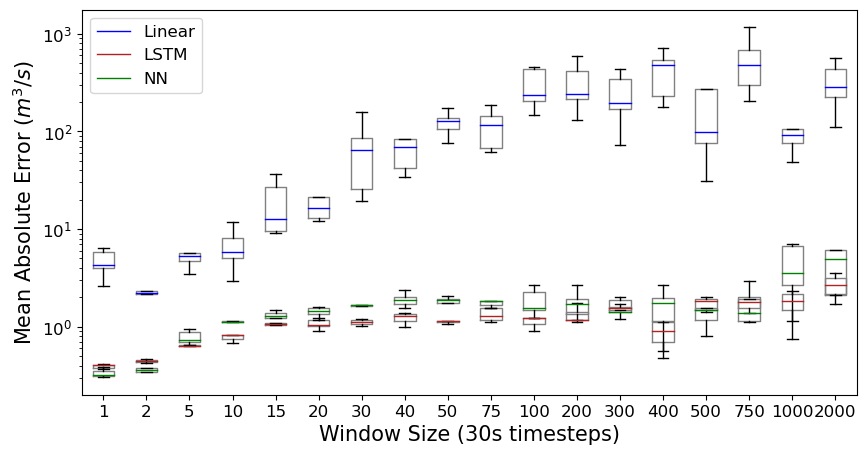

In [81]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (10,5))
fig.patch.set_facecolor('white')


linear_box = ax.boxplot(linear_mae_reshape, showfliers=False, medianprops=dict(color='blue'), boxprops=dict(color='grey'))

lstm_box = ax.boxplot(lstm_mae_reshape, showfliers=False, medianprops=dict(color='firebrick'), boxprops=dict(color='grey'))

dnn_box = ax.boxplot(dnn_mae_reshape, showfliers=False, medianprops=dict(color='green'), boxprops=dict(color='grey'))
c
# ax.plot(window_size,dnn_mae, label = 'DNN')
ax.set_yscale('log')
ax.xaxis.set_tick_params(labelsize=12)
ax.yaxis.set_tick_params(labelsize=12)
#plt.grid()
ax.set_ylabel("Mean Absolute Error ($m^3/s$)", fontsize=15)
ax.set_xlabel("Window Size (30s timesteps)", fontsize=15)
ax.set_xticks(np.arange(1,19,1))
ax.set_xticklabels(window_size)
ax.legend([linear_box["medians"][0], lstm_box["medians"][0], dnn_box["medians"][0]], ['Linear', 'LSTM', 'NN'], fontsize=12)
fig.savefig('models_mae_comparison_5runs.eps')
#plt.show()

ValueError: x and y must have same first dimension, but have shapes (18,) and (5, 18)

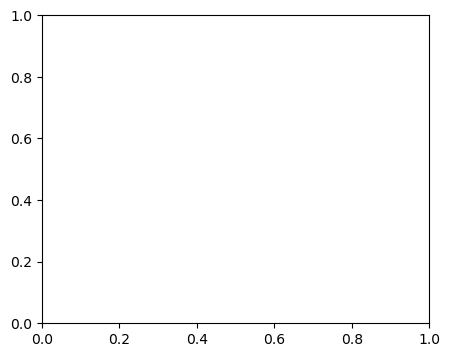

In [19]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (5,4))
fig.patch.set_facecolor('white')

ax.plot(window_size,linear_mae, label = 'Linear')
ax.plot(window_size,lstm_mae, label = 'LSTM')
ax.plot(window_size,dnn_mae, label = 'NN')
ax.set_yscale('log')
ax.set_xscale('log')
plt.grid()
ax.set_ylabel("Mean Absolute Error ($m^3/s$)")
ax.set_xlabel("Window Size (Steps)")
plt.legend()
#fig.savefig('models_mae_comparison.eps')


In [73]:
print(list(residuals.keys())[33::54])

['Run 200_LSTM0', 'Run 200_LSTM1', 'Run 200_LSTM2', 'Run 200_LSTM3', 'Run 200_LSTM4']


# only testing on the window size we want.

In [25]:
window_size = 200
batch_size = 32
seeds = np.arange(0,10,1)

history = {}
val_performance = {}
performance = {}

residuals = {}
true_discharge_vals = {}

lstm_mae = []
linear_mae = []
dnn_mae = []

In [26]:
for SEED in seeds:

    

    #file = "/home/jmanos/notebooks/Highpass_50Hz_data/Rhone_data_continuous_highpass_50hz.h5"
    file = "/home/jmanos/notebooks/Lowpass_50Hz/Rhone_data_continuous_lowpass_50hz.h5"
    #filt = 'Highpass'
    filt = 'Lowpass'
    random.seed(SEED)
    np.random.seed(SEED)
    tf.random.set_seed(SEED)



    linear_model, lstm_model, dnn_model, df_all_chan, das_data_all, f = d2d.import_data(filename = file)

    da = df_all_chan.to_numpy()

    multi_step_window_shuffled = d2d.WindowGenerator(df_all_chan,
                                                    input_width=window_size,
                                                    label_width=1, 
                                                    shift=0,
                                                    label_columns=['Discharge'],
                                                    input_columns=list(np.arange(0,2308,1)),
                                                    shuffle=True,
                                                    batch_size=batch_size)


    history['lstm_'+str(window_size)+'_'+filt+str(SEED)] = d2d.compile_and_fit(lstm_model, multi_step_window_shuffled, learning_rate = 0.001)
    history['linear_'+str(window_size)+'_'+filt+str(SEED)] = d2d.compile_and_fit(linear_model, multi_step_window_shuffled, learning_rate = 0.001)
    history['dnn_'+str(window_size)+'_'+filt+str(SEED)] = d2d.compile_and_fit(dnn_model, multi_step_window_shuffled, learning_rate = 0.001)

    val_performance['lstm_'+str(window_size)+'_'+filt+str(SEED)] = lstm_model.evaluate(multi_step_window_shuffled.val)
    performance['lstm_'+str(window_size)+'_'+filt+str(SEED)] = lstm_model.evaluate(multi_step_window_shuffled.test, verbose=0)
    val_performance['linear_'+str(window_size)+'_'+filt+str(SEED)] = linear_model.evaluate(multi_step_window_shuffled.val)
    performance['linear_'+str(window_size)+'_'+filt+str(SEED)] = linear_model.evaluate(multi_step_window_shuffled.test, verbose=0)
    val_performance['dnn_'+str(window_size)+'_'+filt+str(SEED)] = dnn_model.evaluate(multi_step_window_shuffled.val)
    performance['dnn_'+str(window_size)+'_'+filt+str(SEED)] = dnn_model.evaluate(multi_step_window_shuffled.test, verbose=0)


        
#     dnn_model.save('saved_models/DNN_model_high_50Hz_'+str(SEED)+'.h5')

        
#     linear_model_high.save('saved_models/Linear_model_high_50Hz_'+str(SEED)+'.h5')

    
    pred_on_test_lstm = lstm_model.predict(multi_step_window_shuffled.test).squeeze()
    pred_on_test_lstm = np.asarray(pred_on_test_lstm)
    pred_on_test_linear = linear_model.predict(multi_step_window_shuffled.test).squeeze()
    pred_on_test_linear = np.asarray(pred_on_test_linear)
    pred_on_test_dnn = dnn_model.predict(multi_step_window_shuffled.test).squeeze()
    pred_on_test_dnn = np.asarray(pred_on_test_dnn)

    predictions_test_lstm = (pred_on_test_lstm * multi_step_window_shuffled.dis_std) + multi_step_window_shuffled.dis_mean
    predictions_test_linear = (pred_on_test_linear * multi_step_window_shuffled.dis_std) + multi_step_window_shuffled.dis_mean
    predictions_test_dnn = (pred_on_test_dnn * multi_step_window_shuffled.dis_std) + multi_step_window_shuffled.dis_mean

    test_true_dis = []

    for i in multi_step_window_shuffled.test.as_numpy_iterator():
        test_true_dis.append(i[1])

    test_true_dis = np.asarray(test_true_dis)
    test_true_dis = np.reshape(test_true_dis, test_true_dis.shape[0] * test_true_dis.shape[1])

    test_true_dis_act = (test_true_dis * multi_step_window_shuffled.dis_std) + multi_step_window_shuffled.dis_mean

    residuals['Run ' + str(window_size) + '_LSTM'+str(SEED)] = predictions_test_lstm - test_true_dis_act
    residuals['Run ' + str(window_size) + '_linear'+str(SEED)] = predictions_test_linear - test_true_dis_act
    residuals['Run ' + str(window_size) + '_dnn'+str(SEED)] = predictions_test_dnn - test_true_dis_act

    true_discharge_vals['Run ' + str(window_size)+str(SEED)] = test_true_dis_act

for i in seeds:
    lstm_mae.append(np.sqrt(((residuals['Run ' + str(window_size) + '_LSTM'+str(i)]) ** 2)).mean())
    linear_mae.append(np.sqrt(((residuals['Run ' + str(window_size) + '_linear'+str(i)]) ** 2)).mean()) 
    dnn_mae.append(np.sqrt((residuals['Run ' + str(window_size) + '_dnn'+str(i)]) ** 2).mean()) 


Keys: <KeysViewHDF5 ['DAS Data', 'Discharge', 'Times']>
<MapDataset element_spec=(TensorSpec(shape=(None, 200, 2308), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>
Epoch 1/1000
7/7 [==============================] - 2s 159ms/step - loss: 0.8745 - mean_absolute_error: 0.7572 - val_loss: 0.5776 - val_mean_absolute_error: 0.5625
Epoch 2/1000
7/7 [==============================] - 1s 93ms/step - loss: 0.5869 - mean_absolute_error: 0.6089 - val_loss: 0.4247 - val_mean_absolute_error: 0.5348
Epoch 3/1000
7/7 [==============================] - 1s 93ms/step - loss: 0.3072 - mean_absolute_error: 0.4157 - val_loss: 0.2979 - val_mean_absolute_error: 0.3878
Epoch 4/1000
7/7 [==============================] - 1s 92ms/step - loss: 0.2499 - mean_absolute_error: 0.3667 - val_loss: 0.2886 - val_mean_absolute_error: 0.4000
Epoch 5/1000
7/7 [==============================] - 1s 99ms/step - loss: 0.2199 - mean_absolute_error: 0.3451 - val_loss: 0.2596 - val_me

7/7 [==============================] - 0s 12ms/step - loss: 1494.0460 - mean_absolute_error: 28.1930 - val_loss: 2708.4600 - val_mean_absolute_error: 37.8198
Epoch 8/1000
7/7 [==============================] - 0s 12ms/step - loss: 1984.3214 - mean_absolute_error: 30.6463 - val_loss: 2218.8411 - val_mean_absolute_error: 30.1633
Epoch 9/1000
7/7 [==============================] - 0s 12ms/step - loss: 1340.2063 - mean_absolute_error: 26.1088 - val_loss: 1178.0280 - val_mean_absolute_error: 28.6256
Epoch 10/1000
7/7 [==============================] - 0s 13ms/step - loss: 1471.8644 - mean_absolute_error: 27.8469 - val_loss: 1544.8391 - val_mean_absolute_error: 33.2247
Epoch 11/1000
7/7 [==============================] - 0s 12ms/step - loss: 1510.8170 - mean_absolute_error: 28.7463 - val_loss: 632.8948 - val_mean_absolute_error: 17.3997
Epoch 12/1000
7/7 [==============================] - 0s 12ms/step - loss: 1206.5295 - mean_absolute_error: 24.5372 - val_loss: 2413.0576 - val_mean_absolute_

7/7 [==============================] - 0s 16ms/step - loss: 0.1858 - mean_absolute_error: 0.3535 - val_loss: 0.2431 - val_mean_absolute_error: 0.3728
Epoch 32/1000
7/7 [==============================] - 0s 16ms/step - loss: 0.1386 - mean_absolute_error: 0.2979 - val_loss: 0.1913 - val_mean_absolute_error: 0.3471
Epoch 33/1000
7/7 [==============================] - 0s 16ms/step - loss: 0.1344 - mean_absolute_error: 0.2879 - val_loss: 0.2569 - val_mean_absolute_error: 0.3990
Epoch 34/1000
1/1 [==============================] - 0s 58ms/step
Keys: <KeysViewHDF5 ['DAS Data', 'Discharge', 'Times']>
<MapDataset element_spec=(TensorSpec(shape=(None, 200, 2308), dtype=tf.float64, name=None), TensorSpec(shape=(None, 1, 1), dtype=tf.float64, name=None))>
Epoch 1/1000
7/7 [==============================] - 2s 155ms/step - loss: 0.9383 - mean_absolute_error: 0.8020 - val_loss: 0.5888 - val_mean_absolute_error: 0.5729
Epoch 2/1000
7/7 [==============================] - 1s 98ms/step - loss: 0.4155 - 

7/7 [==============================] - 0s 12ms/step - loss: 14007.9580 - mean_absolute_error: 86.2866 - val_loss: 14658.7559 - val_mean_absolute_error: 87.0689
Epoch 22/1000
7/7 [==============================] - 0s 13ms/step - loss: 31565.3965 - mean_absolute_error: 117.8121 - val_loss: 23381.6641 - val_mean_absolute_error: 112.1240
Epoch 1/1000
7/7 [==============================] - 0s 28ms/step - loss: 2.3281 - mean_absolute_error: 1.1211 - val_loss: 1.0305 - val_mean_absolute_error: 0.8305
Epoch 2/1000
7/7 [==============================] - 1s 144ms/step - loss: 1.3759 - mean_absolute_error: 0.9246 - val_loss: 3.8575 - val_mean_absolute_error: 1.5987
Epoch 3/1000
7/7 [==============================] - 0s 15ms/step - loss: 2.2838 - mean_absolute_error: 1.1582 - val_loss: 1.5614 - val_mean_absolute_error: 1.0081
Epoch 4/1000
7/7 [==============================] - 0s 16ms/step - loss: 0.9585 - mean_absolute_error: 0.7718 - val_loss: 0.6487 - val_mean_absolute_error: 0.6533
Epoch 5/100

Epoch 17/1000
7/7 [==============================] - 1s 93ms/step - loss: 0.0160 - mean_absolute_error: 0.0743 - val_loss: 0.1588 - val_mean_absolute_error: 0.1911
Epoch 18/1000
7/7 [==============================] - 1s 95ms/step - loss: 0.0152 - mean_absolute_error: 0.0751 - val_loss: 0.1543 - val_mean_absolute_error: 0.1938
Epoch 19/1000
7/7 [==============================] - 1s 94ms/step - loss: 0.0131 - mean_absolute_error: 0.0697 - val_loss: 0.1607 - val_mean_absolute_error: 0.1976
Epoch 20/1000
7/7 [==============================] - 1s 95ms/step - loss: 0.0125 - mean_absolute_error: 0.0697 - val_loss: 0.1692 - val_mean_absolute_error: 0.1913
Epoch 21/1000
7/7 [==============================] - 1s 94ms/step - loss: 0.0120 - mean_absolute_error: 0.0689 - val_loss: 0.1719 - val_mean_absolute_error: 0.2014
Epoch 22/1000
7/7 [==============================] - 1s 94ms/step - loss: 0.0175 - mean_absolute_error: 0.0824 - val_loss: 0.1623 - val_mean_absolute_error: 0.2058
Epoch 23/1000
7/

7/7 [==============================] - 0s 17ms/step - loss: 0.0900 - mean_absolute_error: 0.2351 - val_loss: 0.2017 - val_mean_absolute_error: 0.2984
Epoch 21/1000
7/7 [==============================] - 0s 16ms/step - loss: 0.0986 - mean_absolute_error: 0.2540 - val_loss: 0.1998 - val_mean_absolute_error: 0.2944
Epoch 22/1000
7/7 [==============================] - 0s 17ms/step - loss: 0.0660 - mean_absolute_error: 0.2048 - val_loss: 0.1622 - val_mean_absolute_error: 0.2576
Epoch 23/1000
7/7 [==============================] - 0s 16ms/step - loss: 0.0562 - mean_absolute_error: 0.1876 - val_loss: 0.1810 - val_mean_absolute_error: 0.2812
Epoch 24/1000
7/7 [==============================] - 0s 16ms/step - loss: 0.0509 - mean_absolute_error: 0.1852 - val_loss: 0.1705 - val_mean_absolute_error: 0.2516
Epoch 25/1000
7/7 [==============================] - 0s 16ms/step - loss: 0.0231 - mean_absolute_error: 0.1220 - val_loss: 0.1533 - val_mean_absolute_error: 0.2125
Epoch 26/1000
7/7 [===========

Epoch 18/1000
7/7 [==============================] - 1s 93ms/step - loss: 0.0182 - mean_absolute_error: 0.0781 - val_loss: 0.0803 - val_mean_absolute_error: 0.1556
Epoch 19/1000
7/7 [==============================] - 1s 93ms/step - loss: 0.0154 - mean_absolute_error: 0.0782 - val_loss: 0.0840 - val_mean_absolute_error: 0.1534
Epoch 20/1000
7/7 [==============================] - 1s 95ms/step - loss: 0.0116 - mean_absolute_error: 0.0631 - val_loss: 0.0934 - val_mean_absolute_error: 0.1552
Epoch 21/1000
7/7 [==============================] - 1s 93ms/step - loss: 0.0129 - mean_absolute_error: 0.0642 - val_loss: 0.0756 - val_mean_absolute_error: 0.1458
Epoch 22/1000
7/7 [==============================] - 1s 91ms/step - loss: 0.0113 - mean_absolute_error: 0.0651 - val_loss: 0.0753 - val_mean_absolute_error: 0.1373
Epoch 23/1000
7/7 [==============================] - 1s 93ms/step - loss: 0.0091 - mean_absolute_error: 0.0552 - val_loss: 0.0898 - val_mean_absolute_error: 0.1519
Epoch 24/1000
7/

7/7 [==============================] - 0s 14ms/step - loss: 0.7939 - mean_absolute_error: 0.6806 - val_loss: 0.9100 - val_mean_absolute_error: 0.7409
Epoch 4/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.6164 - mean_absolute_error: 0.6255 - val_loss: 0.3922 - val_mean_absolute_error: 0.5027
Epoch 5/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.4486 - mean_absolute_error: 0.5483 - val_loss: 0.6821 - val_mean_absolute_error: 0.7070
Epoch 6/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.4201 - mean_absolute_error: 0.5315 - val_loss: 0.2442 - val_mean_absolute_error: 0.3923
Epoch 7/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.3106 - mean_absolute_error: 0.4331 - val_loss: 0.4461 - val_mean_absolute_error: 0.4916
Epoch 8/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.2971 - mean_absolute_error: 0.3815 - val_loss: 0.2516 - val_mean_absolute_error: 0.3691
Epoch 9/1000
7/7 [=================

7/7 [==============================] - 1s 93ms/step - loss: 0.0158 - mean_absolute_error: 0.0657 - val_loss: 0.1122 - val_mean_absolute_error: 0.2049
Epoch 21/1000
7/7 [==============================] - 1s 93ms/step - loss: 0.0199 - mean_absolute_error: 0.0836 - val_loss: 0.0855 - val_mean_absolute_error: 0.1604
Epoch 22/1000
7/7 [==============================] - 1s 93ms/step - loss: 0.0198 - mean_absolute_error: 0.0882 - val_loss: 0.1025 - val_mean_absolute_error: 0.2250
Epoch 23/1000
7/7 [==============================] - 1s 95ms/step - loss: 0.0266 - mean_absolute_error: 0.1116 - val_loss: 0.0966 - val_mean_absolute_error: 0.1963
Epoch 24/1000
7/7 [==============================] - 1s 94ms/step - loss: 0.0294 - mean_absolute_error: 0.1118 - val_loss: 0.1056 - val_mean_absolute_error: 0.1941
Epoch 25/1000
7/7 [==============================] - 1s 94ms/step - loss: 0.0180 - mean_absolute_error: 0.0947 - val_loss: 0.1136 - val_mean_absolute_error: 0.2078
Epoch 1/1000
7/7 [============

7/7 [==============================] - 0s 15ms/step - loss: 0.0083 - mean_absolute_error: 0.0627 - val_loss: 0.2258 - val_mean_absolute_error: 0.2122
Epoch 20/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0076 - mean_absolute_error: 0.0606 - val_loss: 0.2245 - val_mean_absolute_error: 0.2128
Epoch 21/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0042 - mean_absolute_error: 0.0421 - val_loss: 0.2265 - val_mean_absolute_error: 0.1933
Epoch 22/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0040 - mean_absolute_error: 0.0432 - val_loss: 0.2201 - val_mean_absolute_error: 0.1947
Epoch 23/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0025 - mean_absolute_error: 0.0321 - val_loss: 0.2197 - val_mean_absolute_error: 0.1849
Epoch 24/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0019 - mean_absolute_error: 0.0257 - val_loss: 0.2209 - val_mean_absolute_error: 0.1844
Epoch 25/1000
7/7 [===========

Epoch 16/1000
7/7 [==============================] - 1s 93ms/step - loss: 0.0333 - mean_absolute_error: 0.1186 - val_loss: 0.1198 - val_mean_absolute_error: 0.2040
Epoch 17/1000
7/7 [==============================] - 1s 91ms/step - loss: 0.0259 - mean_absolute_error: 0.1057 - val_loss: 0.1168 - val_mean_absolute_error: 0.1938
Epoch 18/1000
7/7 [==============================] - 1s 93ms/step - loss: 0.0229 - mean_absolute_error: 0.0943 - val_loss: 0.1130 - val_mean_absolute_error: 0.1877
Epoch 19/1000
7/7 [==============================] - 1s 88ms/step - loss: 0.0188 - mean_absolute_error: 0.0821 - val_loss: 0.1113 - val_mean_absolute_error: 0.1757
Epoch 20/1000
7/7 [==============================] - 1s 92ms/step - loss: 0.0154 - mean_absolute_error: 0.0729 - val_loss: 0.1028 - val_mean_absolute_error: 0.1643
Epoch 21/1000
7/7 [==============================] - 1s 91ms/step - loss: 0.0150 - mean_absolute_error: 0.0722 - val_loss: 0.1116 - val_mean_absolute_error: 0.1727
Epoch 22/1000
7/

7/7 [==============================] - 0s 11ms/step - loss: 153.1808 - mean_absolute_error: 8.3832 - val_loss: 147.4175 - val_mean_absolute_error: 9.2495
Epoch 14/1000
7/7 [==============================] - 0s 12ms/step - loss: 136.1046 - mean_absolute_error: 8.6739 - val_loss: 87.3696 - val_mean_absolute_error: 6.6633
Epoch 15/1000
7/7 [==============================] - 0s 11ms/step - loss: 238.3720 - mean_absolute_error: 10.5799 - val_loss: 127.4660 - val_mean_absolute_error: 8.0972
Epoch 16/1000
7/7 [==============================] - 0s 11ms/step - loss: 166.2020 - mean_absolute_error: 8.5777 - val_loss: 137.3948 - val_mean_absolute_error: 8.4230
Epoch 17/1000
7/7 [==============================] - 0s 11ms/step - loss: 377.6491 - mean_absolute_error: 13.3094 - val_loss: 264.9426 - val_mean_absolute_error: 12.0706
Epoch 18/1000
7/7 [==============================] - 0s 12ms/step - loss: 359.5478 - mean_absolute_error: 12.7102 - val_loss: 519.3159 - val_mean_absolute_error: 16.7919
Ep

7/7 [==============================] - 0s 15ms/step - loss: 0.0119 - mean_absolute_error: 0.0883 - val_loss: 0.2764 - val_mean_absolute_error: 0.2968
Epoch 39/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0150 - mean_absolute_error: 0.1022 - val_loss: 0.2643 - val_mean_absolute_error: 0.2950
Epoch 40/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0136 - mean_absolute_error: 0.0962 - val_loss: 0.2515 - val_mean_absolute_error: 0.2671
Epoch 41/1000
7/7 [==============================] - 0s 14ms/step - loss: 0.0115 - mean_absolute_error: 0.0895 - val_loss: 0.2765 - val_mean_absolute_error: 0.3116
Epoch 42/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0111 - mean_absolute_error: 0.0883 - val_loss: 0.2535 - val_mean_absolute_error: 0.2567
Epoch 43/1000
7/7 [==============================] - 0s 15ms/step - loss: 0.0085 - mean_absolute_error: 0.0756 - val_loss: 0.2580 - val_mean_absolute_error: 0.2941
Epoch 44/1000
7/7 [===========

Epoch 3/1000
7/7 [==============================] - 0s 11ms/step - loss: 17831.6113 - mean_absolute_error: 81.5907 - val_loss: 9367.6055 - val_mean_absolute_error: 65.4482
Epoch 4/1000
7/7 [==============================] - 0s 11ms/step - loss: 6415.2329 - mean_absolute_error: 51.4648 - val_loss: 4141.2358 - val_mean_absolute_error: 45.4784
Epoch 5/1000
7/7 [==============================] - 0s 11ms/step - loss: 5421.6724 - mean_absolute_error: 48.3264 - val_loss: 4107.1338 - val_mean_absolute_error: 44.6764
Epoch 6/1000
7/7 [==============================] - 0s 11ms/step - loss: 2799.6770 - mean_absolute_error: 32.0068 - val_loss: 4336.7500 - val_mean_absolute_error: 42.1047
Epoch 7/1000
7/7 [==============================] - 0s 12ms/step - loss: 1461.7386 - mean_absolute_error: 25.4912 - val_loss: 1764.2592 - val_mean_absolute_error: 26.5297
Epoch 8/1000
7/7 [==============================] - 0s 12ms/step - loss: 899.4105 - mean_absolute_error: 20.5655 - val_loss: 593.9023 - val_mean

7/7 [==============================] - 0s 16ms/step - loss: 7.4060e-04 - mean_absolute_error: 0.0137 - val_loss: 0.2481 - val_mean_absolute_error: 0.2140
Epoch 31/1000
7/7 [==============================] - 0s 15ms/step - loss: 6.4989e-04 - mean_absolute_error: 0.0129 - val_loss: 0.2476 - val_mean_absolute_error: 0.2133
Epoch 32/1000
7/7 [==============================] - 0s 15ms/step - loss: 5.3599e-04 - mean_absolute_error: 0.0121 - val_loss: 0.2477 - val_mean_absolute_error: 0.2134
Epoch 33/1000
7/7 [==============================] - 0s 15ms/step - loss: 4.6270e-04 - mean_absolute_error: 0.0113 - val_loss: 0.2470 - val_mean_absolute_error: 0.2123
Epoch 34/1000
7/7 [==============================] - 0s 15ms/step - loss: 3.5308e-04 - mean_absolute_error: 0.0095 - val_loss: 0.2470 - val_mean_absolute_error: 0.2110
Epoch 35/1000
7/7 [==============================] - 0s 14ms/step - loss: 3.1138e-04 - mean_absolute_error: 0.0079 - val_loss: 0.2471 - val_mean_absolute_error: 0.2113
Epoch 

7/7 [==============================] - 1s 92ms/step - loss: 0.0356 - mean_absolute_error: 0.1266 - val_loss: 0.1809 - val_mean_absolute_error: 0.2337
Epoch 15/1000
7/7 [==============================] - 1s 89ms/step - loss: 0.0571 - mean_absolute_error: 0.1499 - val_loss: 0.1752 - val_mean_absolute_error: 0.2673
Epoch 16/1000
7/7 [==============================] - 1s 94ms/step - loss: 0.0289 - mean_absolute_error: 0.1140 - val_loss: 0.1783 - val_mean_absolute_error: 0.2241
Epoch 17/1000
7/7 [==============================] - 1s 93ms/step - loss: 0.0288 - mean_absolute_error: 0.1140 - val_loss: 0.1994 - val_mean_absolute_error: 0.2478
Epoch 18/1000
7/7 [==============================] - 1s 90ms/step - loss: 0.0301 - mean_absolute_error: 0.1169 - val_loss: 0.1700 - val_mean_absolute_error: 0.2236
Epoch 19/1000
7/7 [==============================] - 1s 90ms/step - loss: 0.0225 - mean_absolute_error: 0.1024 - val_loss: 0.1800 - val_mean_absolute_error: 0.2258
Epoch 20/1000
7/7 [===========

7/7 [==============================] - 1s 89ms/step - loss: 0.1974 - mean_absolute_error: 0.3368 - val_loss: 0.2872 - val_mean_absolute_error: 0.4144
Epoch 6/1000
7/7 [==============================] - 1s 91ms/step - loss: 0.1926 - mean_absolute_error: 0.3143 - val_loss: 0.2669 - val_mean_absolute_error: 0.3814
Epoch 7/1000
7/7 [==============================] - 1s 91ms/step - loss: 0.1693 - mean_absolute_error: 0.2983 - val_loss: 0.2572 - val_mean_absolute_error: 0.3686
Epoch 8/1000
7/7 [==============================] - 1s 93ms/step - loss: 0.1262 - mean_absolute_error: 0.2566 - val_loss: 0.1790 - val_mean_absolute_error: 0.3086
Epoch 9/1000
7/7 [==============================] - 1s 91ms/step - loss: 0.0954 - mean_absolute_error: 0.2152 - val_loss: 0.1522 - val_mean_absolute_error: 0.2765
Epoch 10/1000
7/7 [==============================] - 1s 91ms/step - loss: 0.0778 - mean_absolute_error: 0.1901 - val_loss: 0.1562 - val_mean_absolute_error: 0.2936
Epoch 11/1000
7/7 [===============

7/7 [==============================] - 0s 11ms/step - loss: 5047.4321 - mean_absolute_error: 52.4620 - val_loss: 7103.7300 - val_mean_absolute_error: 67.1435
Epoch 18/1000
7/7 [==============================] - 0s 12ms/step - loss: 5294.0889 - mean_absolute_error: 48.0296 - val_loss: 1836.4119 - val_mean_absolute_error: 31.6226
Epoch 19/1000
7/7 [==============================] - 0s 11ms/step - loss: 5426.8081 - mean_absolute_error: 54.0029 - val_loss: 8680.7363 - val_mean_absolute_error: 74.9423
Epoch 20/1000
7/7 [==============================] - 0s 12ms/step - loss: 5959.2612 - mean_absolute_error: 52.4920 - val_loss: 1986.2317 - val_mean_absolute_error: 22.5015
Epoch 1/1000
7/7 [==============================] - 0s 28ms/step - loss: 2.5128 - mean_absolute_error: 1.1414 - val_loss: 2.3270 - val_mean_absolute_error: 1.2097
Epoch 2/1000
7/7 [==============================] - 0s 15ms/step - loss: 1.9890 - mean_absolute_error: 0.9990 - val_loss: 1.2970 - val_mean_absolute_error: 0.8798


Epoch 23/1000
7/7 [==============================] - 1s 96ms/step - loss: 0.0122 - mean_absolute_error: 0.0650 - val_loss: 0.0720 - val_mean_absolute_error: 0.1591
Epoch 24/1000
7/7 [==============================] - 1s 96ms/step - loss: 0.0106 - mean_absolute_error: 0.0663 - val_loss: 0.0551 - val_mean_absolute_error: 0.1407
Epoch 25/1000
7/7 [==============================] - 1s 93ms/step - loss: 0.0129 - mean_absolute_error: 0.0663 - val_loss: 0.0663 - val_mean_absolute_error: 0.1391
Epoch 26/1000
7/7 [==============================] - 1s 97ms/step - loss: 0.0181 - mean_absolute_error: 0.0777 - val_loss: 0.0721 - val_mean_absolute_error: 0.1709
Epoch 27/1000
7/7 [==============================] - 1s 93ms/step - loss: 0.0126 - mean_absolute_error: 0.0670 - val_loss: 0.0580 - val_mean_absolute_error: 0.1423
Epoch 28/1000
7/7 [==============================] - 1s 93ms/step - loss: 0.0118 - mean_absolute_error: 0.0718 - val_loss: 0.0583 - val_mean_absolute_error: 0.1463
Epoch 29/1000
7/

7/7 [==============================] - 0s 12ms/step - loss: 1038.5159 - mean_absolute_error: 21.7664 - val_loss: 2154.4690 - val_mean_absolute_error: 34.2567
Epoch 18/1000
7/7 [==============================] - 0s 12ms/step - loss: 1912.5510 - mean_absolute_error: 30.7044 - val_loss: 1062.4575 - val_mean_absolute_error: 23.6261
Epoch 1/1000
7/7 [==============================] - 0s 29ms/step - loss: 1.9285 - mean_absolute_error: 1.0982 - val_loss: 1.0757 - val_mean_absolute_error: 0.7483
Epoch 2/1000
7/7 [==============================] - 0s 16ms/step - loss: 1.2870 - mean_absolute_error: 0.7909 - val_loss: 2.4170 - val_mean_absolute_error: 0.8889
Epoch 3/1000
7/7 [==============================] - 0s 16ms/step - loss: 0.9448 - mean_absolute_error: 0.7209 - val_loss: 1.9416 - val_mean_absolute_error: 0.9524
Epoch 4/1000
7/7 [==============================] - 0s 16ms/step - loss: 1.2013 - mean_absolute_error: 0.7371 - val_loss: 0.3957 - val_mean_absolute_error: 0.4727
Epoch 5/1000
7/7 [

In [31]:
lstm_mae = []
linear_mae = []
dnn_mae = []

for i in seeds:
    lstm_mae.append(np.sqrt(((residuals['Run ' + str(window_size) + '_LSTM'+str(i)]) ** 2)))
    linear_mae.append(np.sqrt(((residuals['Run ' + str(window_size) + '_linear'+str(i)]) ** 2))) 
    dnn_mae.append(np.sqrt((residuals['Run ' + str(window_size) + '_dnn'+str(i)]) ** 2)) 

In [32]:
lstm_ae = np.asarray(lstm_mae)
linear_ae = np.asarray(linear_mae)
dnn_ae = np.asarray(dnn_mae)

lstm_mea = lstm_ae.reshape(lstm_ae.shape[0]*lstm_ae.shape[1])
linear_mea = linear_ae.reshape(linear_ae.shape[0]*linear_ae.shape[1])
dnn_mea = dnn_ae.reshape(dnn_ae.shape[0]*dnn_ae.shape[1])

In [33]:
print(dnn_mea.mean())
print(lstm_mea.mean())

0.9576519138065254
0.5979823867813625


In [36]:
linear_model.summary()

Model: "sequential_69"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_46 (Flatten)        (None, 461600)            0         
                                                                 
 dense_115 (Dense)           (None, 1)                 461601    
                                                                 
Total params: 461,601
Trainable params: 461,601
Non-trainable params: 0
_________________________________________________________________
